## Predicting Formula 1 Race Outcomes and Evaluating Betting Performance

### Index

1. **Problem Definition**
2. **Data Collection and Preprocessing**
3. **Exploratory Data Analysis (EDA)**
4. **Feature Engineering**
5. **Modeling Approaches**
   - 5.1. Predicting the Race Winner (Classification)
   - 5.2. Predicting Race Positions (Regression)
   - 5.3. Predicting Race Positions (Multiclass Classification)
6. **Model Evaluation and Comparison**
7. **Betting Odds Analysis**
   - 7.1. Collecting Betting Odds
   - 7.2. Simulating Betting Outcomes
   - 7.3. Evaluating Profitability of Predictions
8. **Insights and Conclusions**
9. **Future Work**


### EDA & Preprocessing

In [8]:
import numpy as np
import pandas as pd

In [9]:
circuits = pd.read_csv('data/circuits.csv')
constructor_standings = pd.read_csv('data/constructor_standings.csv')
constructors = pd.read_csv('data/constructors.csv')
driver_standings = pd.read_csv('data/driver_standings.csv')
drivers = pd.read_csv('data/drivers.csv')
qualifying = pd.read_csv('data/qualifying.csv')
races = pd.read_csv('data/races.csv')
results = pd.read_csv('data/results.csv')

In [10]:
print("Shape of circuits:", circuits.shape)
print("Shape of constructor_standings:", constructor_standings.shape)
print("Shape of constructors:", constructors.shape)
print("Shape of driver_standings:", driver_standings.shape)
print("Shape of drivers:", drivers.shape)
print("Shape of qualifying:", qualifying.shape)
print("Shape of races:", races.shape)
print("Shape of results:", results.shape)

Shape of circuits: (77, 9)
Shape of constructor_standings: (13391, 7)
Shape of constructors: (212, 5)
Shape of driver_standings: (34862, 7)
Shape of drivers: (860, 9)
Shape of qualifying: (10493, 9)
Shape of races: (1125, 18)
Shape of results: (26758, 18)


Key Observations
Datasets and Sizes:

Small datasets: circuits, constructors, drivers, status.
Medium datasets: constructor_results, constructor_standings, races, results, qualifying, sprint_results.
Large datasets: lap_times, pit_stops.
Columns with IDs:

raceId, driverId, constructorId are central identifiers linking multiple datasets.
Missing Data:

qualifying has missing values in q2 and q3.
races has placeholders like \N in session times.

Common Relationships:

races connects with circuits (via circuitId), results and qualifying (via raceId).
drivers and constructors connect with results (via driverId, constructorId).
lap_times and pit_stops detail race events (via raceId, driverId).

In [11]:
# Ensure the columns have the same data type before merging
races['raceId'] = races['raceId'].astype(int)
circuits['circuitId'] = circuits['circuitId'].astype(int)
results['raceId'] = results['raceId'].astype(int)
results['driverId'] = results['driverId'].astype(int)
results['constructorId'] = results['constructorId'].astype(int)
drivers['driverId'] = drivers['driverId'].astype(int)
constructors['constructorId'] = constructors['constructorId'].astype(int)
driver_standings['raceId'] = driver_standings['raceId'].astype(int)
driver_standings['driverId'] = driver_standings['driverId'].astype(int)
constructor_standings['raceId'] = constructor_standings['raceId'].astype(int)
constructor_standings['constructorId'] = constructor_standings['constructorId'].astype(int)
qualifying['raceId'] = qualifying['raceId'].astype(int)
qualifying['driverId'] = qualifying['driverId'].astype(int)

# Merge datasets using INNER JOINs with custom suffixes
merged_data = pd.merge(races, circuits, on="circuitId", how="inner", suffixes=('_races', '_circuits'))
merged_data = pd.merge(merged_data, results, on="raceId", how="inner", suffixes=('', '_results'))
merged_data = pd.merge(merged_data, drivers, on="driverId", how="inner", suffixes=('', '_drivers'))
merged_data = pd.merge(merged_data, constructors, on="constructorId", how="inner", suffixes=('', '_constructors'))
merged_data = pd.merge(merged_data, driver_standings, on=["raceId", "driverId"], how="inner", suffixes=('', '_driver_standings'))
merged_data = pd.merge(merged_data, constructor_standings, on=["raceId", "constructorId"], how="inner", suffixes=('', '_constructor_standings'))
merged_data = pd.merge(merged_data, qualifying, on=["raceId", "driverId"], how="inner", suffixes=('', '_qualifying'))


In [12]:
print(merged_data.shape)
merged_data.describe

(10242, 72)


<bound method NDFrame.describe of        raceId  year  round  circuitId                name_races        date  \
0           1  2009      1          1     Australian Grand Prix  2009-03-29   
1           1  2009      1          1     Australian Grand Prix  2009-03-29   
2           2  2009      2          2      Malaysian Grand Prix  2009-04-05   
3           2  2009      2          2      Malaysian Grand Prix  2009-04-05   
4           3  2009      3         17        Chinese Grand Prix  2009-04-19   
...       ...   ...    ...        ...                       ...         ...   
10237     944  2015     18         18      Brazilian Grand Prix  2015-11-15   
10238     943  2015     17         32        Mexican Grand Prix  2015-11-01   
10239     943  2015     17         32        Mexican Grand Prix  2015-11-01   
10240     942  2015     16         69  United States Grand Prix  2015-10-25   
10241     942  2015     16         69  United States Grand Prix  2015-10-25   

           time  

In [13]:
merged_data.isnull().sum()

raceId                  0
year                    0
round                   0
circuitId               0
name_races              0
                       ..
number_qualifying       0
position_qualifying     0
q1                      2
q2                     13
q3                     27
Length: 72, dtype: int64

veiem que tot i que posa que només hi ha 13 i 27 nuls respectivament hi ha molts valors que son \N i que pertant també son nuls. Començem per canviar \N per NaN

In [14]:
merged_data.replace('\\N', np.nan, inplace=True)

In [15]:
merged_data.isnull().sum()

raceId                    0
year                      0
round                     0
circuitId                 0
name_races                0
                       ... 
number_qualifying         0
position_qualifying       0
q1                      151
q2                     4423
q3                     6628
Length: 72, dtype: int64

Ara si veiem que hi ha molts nuls a q2 i q3. Understanding the Problem
q1: Represents all drivers with qualifying times (minimal missing values).
q2: Only available for the top 15 fastest drivers from q1.
q3: Only available for the top 10 fastest drivers from q2.
These missing values are not random but instead a result of the qualification rules. They carry information about the driver's performance and ranking. For example:

A missing value in q2 means the driver did not make it past q1.
A missing value in q3 means the driver did not make it past q2.

El format de classificació de 3 rondes es va introudir al 2006 i llavors només tindria sentit posar columens binàries sobre si van passar q1 i la q2 a partir del 2006. Per simplificar eliminaré les columnes q2 i q3

In [16]:
merged_data.columns

Index(['raceId', 'year', 'round', 'circuitId', 'name_races', 'date', 'time',
       'url_races', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date',
       'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time',
       'circuitRef', 'name_circuits', 'location', 'country', 'lat', 'lng',
       'alt', 'url_circuits', 'resultId', 'driverId', 'constructorId',
       'number', 'grid', 'position', 'positionText', 'positionOrder', 'points',
       'laps', 'time_results', 'milliseconds', 'fastestLap', 'rank',
       'fastestLapTime', 'fastestLapSpeed', 'statusId', 'driverRef',
       'number_drivers', 'code', 'forename', 'surname', 'dob', 'nationality',
       'url', 'constructorRef', 'name', 'nationality_constructors',
       'url_constructors', 'driverStandingsId', 'points_driver_standings',
       'position_driver_standings', 'positionText_driver_standings', 'wins',
       'constructorStandingsId', 'points_constructor_standings',
       'position_constructor_standings'

In [17]:
# Columns to drop
columns_to_drop = [
    'driverId', 'constructorId', 'statusId', 'qualifyId', 'constructorResultsId', 'constructorStandingsId', 'driverStandingsId',
    'url_races', 'tiime', 'url_circuits', 'number', 'url_results', 'url', 'code', 'url_drivers', 'resultId', 'q2', 'q3',
    'name_circuits', 'location', 'lat', 'lng', 'alt', 'url_drivers', 'constructorStandingsId', 'time', 'driverRef',
    'number', 'code', 'url_constructors', 'url_driver_standings', 'positionText', 'positionOrder', 'position_qualifying',
    'time_results', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'number_drivers',
    'positionText_driver_standings', 'constructorId_qualifying', 'number_qualifying', 'position_qualifying',
    'positionText_constructor_standings', 'positionOrder_constructor_standings', 'points_constructor_standings',
    'wins_constructor_standings', 'positionText_constructor_standings', 'constructorRef', 'position_constructor_standings',
    'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time'
]


# Lists of status IDs
driver_error_status_ids = [3, 4, 20, 28, 68, 73, 82, 89, 100, 104, 107, 130, 139]
constructor_error_status_ids = [
    5, 6, 7, 8, 9, 10, 21, 22, 23, 24, 25, 26, 27, 29, 30, 32, 33, 34, 35, 36, 37,
    38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 51, 59, 60, 61, 63, 64, 65, 66,
    67, 69, 70, 71, 72, 74, 75, 76, 79, 80, 83, 84, 86, 87, 91, 94, 95, 98, 99,
    101, 102, 103, 105, 106, 108, 109, 110, 121, 126, 129, 131, 132, 135, 140, 141
]
finished_status_ids = [
    1, 11, 12, 13, 14, 15, 16, 17, 18, 19, 45, 50, 53, 55, 88,
    111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123,
    124, 125, 127, 128, 133, 134
]

# Initialize columns with zeros
merged_data['driver_dnf'] = 0
merged_data['constructor_dnf'] = 0

# Set driver_dnf to 1 where statusId is a driver error
merged_data.loc[merged_data['statusId'].isin(driver_error_status_ids), 'driver_dnf'] = 1

# Set constructor_dnf to 1 where statusId is a constructor error
merged_data.loc[merged_data['statusId'].isin(constructor_error_status_ids), 'constructor_dnf'] = 1

# Ensure that drivers who finished the race have zeros in both columns
merged_data.loc[merged_data['statusId'].isin(finished_status_ids), ['driver_dnf', 'constructor_dnf']] = 0

# Drop the specified columns
merged_data = merged_data.drop(columns=columns_to_drop, errors='ignore')



In [18]:
merged_data.head()

,raceId,year,round,circuitId,name_races,date,circuitRef,country,grid,position,...,dob,nationality,name,nationality_constructors,points_driver_standings,position_driver_standings,wins,q1,driver_dnf,constructor_dnf
0,1,2009,1,1,Australian Grand Prix,2009-03-29,albert_park,Australia,1,1,...,1980-01-19,British,Brawn,British,10.0,1,1,1:25.211,0,0
1,1,2009,1,1,Australian Grand Prix,2009-03-29,albert_park,Australia,2,2,...,1972-05-23,Brazilian,Brawn,British,8.0,2,0,1:25.006,0,0
2,2,2009,2,2,Malaysian Grand Prix,2009-04-05,sepang,Malaysia,1,1,...,1980-01-19,British,Brawn,British,15.0,1,2,1:35.058,0,0
3,2,2009,2,2,Malaysian Grand Prix,2009-04-05,sepang,Malaysia,8,5,...,1972-05-23,Brazilian,Brawn,British,10.0,2,0,1:34.681,0,0
4,3,2009,3,17,Chinese Grand Prix,2009-04-19,shanghai,China,5,3,...,1980-01-19,British,Brawn,British,21.0,1,2,1:35.533,0,0


In [19]:
merged_data.rename(columns={
    'name_races': 'GP_name',
    'nationality': 'driver_nationality',
    'points_driver_standings': 'total_points',
    'position_driver_standings': 'championship_position',
    'name': 'constructor_name',
    'wins' : 'number_wins'
}, inplace = True)

In [20]:
merged_data.columns

Index(['raceId', 'year', 'round', 'circuitId', 'GP_name', 'date', 'circuitRef',
       'country', 'grid', 'position', 'points', 'laps', 'forename', 'surname',
       'dob', 'driver_nationality', 'constructor_name',
       'nationality_constructors', 'total_points', 'championship_position',
       'number_wins', 'q1', 'driver_dnf', 'constructor_dnf'],
      dtype='object')

In [21]:
# Combine 'forename' and 'surname' into a single column called 'driver_name'
merged_data['driver_name'] = merged_data['forename'] + ' ' + merged_data['surname']

# Drop the original 'forename' and 'surname' columns as they are no longer needed
merged_data = merged_data.drop(columns=['forename', 'surname'], errors='ignore')

#tranform the 'dob' and 'date' column to datetime
merged_data['dob'] = pd.to_datetime(merged_data['dob'])
merged_data['date'] = pd.to_datetime(merged_data['date'])
# Calculate the age of the driver at the time of the Grand Prix in days
merged_data['age_at_gp_in_days'] = (merged_data['date'] - merged_data['dob']).dt.days


# Display the first few rows to confirm the changes
merged_data.head()

,raceId,year,round,circuitId,GP_name,date,circuitRef,country,grid,position,...,constructor_name,nationality_constructors,total_points,championship_position,number_wins,q1,driver_dnf,constructor_dnf,driver_name,age_at_gp_in_days
0,1,2009,1,1,Australian Grand Prix,2009-03-29,albert_park,Australia,1,1,...,Brawn,British,10.0,1,1,1:25.211,0,0,Jenson Button,10662
1,1,2009,1,1,Australian Grand Prix,2009-03-29,albert_park,Australia,2,2,...,Brawn,British,8.0,2,0,1:25.006,0,0,Rubens Barrichello,13459
2,2,2009,2,2,Malaysian Grand Prix,2009-04-05,sepang,Malaysia,1,1,...,Brawn,British,15.0,1,2,1:35.058,0,0,Jenson Button,10669
3,2,2009,2,2,Malaysian Grand Prix,2009-04-05,sepang,Malaysia,8,5,...,Brawn,British,10.0,2,0,1:34.681,0,0,Rubens Barrichello,13466
4,3,2009,3,17,Chinese Grand Prix,2009-04-19,shanghai,China,5,3,...,Brawn,British,21.0,1,2,1:35.533,0,0,Jenson Button,10683


In [22]:
nationality_to_country = {
    "German": "Germany",
    "Dutch": "Netherlands",
    "British": "UK",
    "Brazilian": "Brazil",
    "Finnish": "Finland",
    "French": "France",
    "Austrian": "Austria",
    "Italian": "Italy",
    "Japanese": "Japan",
    "Australian": "Australia",
    "Portuguese": "Portugal",
    "Monegasque": "Monaco",
    "Belgian": "Belgium",
    "Swiss": "Switzerland",
    "Danish": "Denmark",
    "Canadian": "Canada",
    "Argentine": "Argentina",
    "Spanish": "Spain",
    "Colombian": "Colombia",
    "Czech": "Czech Republic",
    "Malaysian": "Malaysia",
    "Irish": "Ireland",
    "Hungarian": "Hungary",
    "Indian": "India",
    "American": "USA",
    "Polish": "Poland",
    "Russian": "Russia",
    "Venezuelan": "Venezuela",
    "Mexican": "Mexico",
    "Swedish": "Sweden",
    "Indonesian": "Indonesia",
    "New Zealander": "New Zealand",
    "Thai": "Thailand",
}

In [23]:
# Map driver_nationality to driver_country using the nationality_to_country dictionary
merged_data['driver_country'] = merged_data['driver_nationality'].map(nationality_to_country)

merged_data['constructor_country'] = merged_data['nationality_constructors'].map(nationality_to_country)

# drop driver_nationality column
merged_data.drop(columns=['driver_nationality','nationality_constructors' ], inplace=True)

In [24]:
merged_data = merged_data.sort_values(by=['year', 'round'])

In [25]:
merged_data.to_csv('data/merged_data.csv', index=False)

### Step 1: Data Structure Analysis

In [26]:
# Step 1: Understand the Data Structure

# Display the shape of the dataset
dataset_shape = merged_data.shape

# List column names and their data types
column_info = merged_data.dtypes

# Sample unique values for each column
unique_values_sample = merged_data.nunique()

# Check for missing values in each column
missing_values = merged_data.isnull().sum()

# Compile the information into a summary table
data_overview = pd.DataFrame({
    "Data Type": column_info,
    "Unique Values": unique_values_sample,
    "Missing Values": missing_values,
    "Missing %": (missing_values / dataset_shape[0]) * 100
})


dataset_shape, data_overview

((10242, 24),
                             Data Type  Unique Values  Missing Values  \
 raceId                          int32            494               0   
 year                            int64             31               0   
 round                           int64             24               0   
 circuitId                       int64             43               0   
 GP_name                        object             43               0   
 date                   datetime64[ns]            494               0   
 circuitRef                     object             43               0   
 country                        object             31               0   
 grid                            int64             27               0   
 position                       object             24            2176   
 points                        float64             29               0   
 laps                            int64             85               0   
 dob                    datetime64[ns

### Observations:

- Dataset Size: The dataset contains 8,131 rows and 20 columns.
- Column Overview: Columns include a mix of numerical (e.g., grid, laps), categorical (e.g., GP_name, position), and datetime (e.g., date, dob) types.
- Unique Values: Several columns, such as driver_name and constructor_name, have high cardinality, indicating diversity in data points.
- Missing Data: There are no missing values in the dataset.

### Step 2: Summary Statistics

In [27]:
# Step 2: Summary Statistics

# Generate descriptive statistics for numeric columns
numeric_summary = merged_data.describe()

# Display statistics for categorical columns
categorical_summary = merged_data.select_dtypes(include=['object']).describe()

numeric_summary, categorical_summary


(             raceId          year         round     circuitId          grid  \
 count  10242.000000  10242.000000  10242.000000  10242.000000  10242.000000   
 mean     634.808143   2011.510447     10.030072     20.117360     10.955868   
 std      427.094437      8.482999      5.673941     20.917975      6.264100   
 min        1.000000   1994.000000      1.000000      1.000000      0.000000   
 25%      161.000000   2006.000000      5.000000      7.000000      6.000000   
 50%      875.000000   2012.000000     10.000000     14.000000     11.000000   
 75%     1009.000000   2018.000000     15.000000     22.000000     16.000000   
 max     1144.000000   2024.000000     24.000000     80.000000     26.000000   
 
              points          laps  total_points  championship_position  \
 count  10242.000000  10242.000000  10242.000000           10242.000000   
 mean       3.651142     52.157196     38.064782              11.374829   
 std        6.102380     19.305663     63.788377     


### Key Insights:

- Numerical Summary:
    - Columns like grid and laps have wide ranges, which suggests varying conditions across races.
    - Some variables like total_points and championship_position could potentially be strong predictors for the winner.

- Categorical Summary:
    - GP_name has 31 unique values, which corresponds to different Grand Prix events.
    - driver_name has 156 unique entries, reflecting a diverse set of participants.
    - Variables such as q1, q2, and q3 include significant amounts of non-informative data (\N), which may require cleaning or imputation.

In [28]:
# Convert 'position' column to numeric, forcing errors to NaN
merged_data['position'] = pd.to_numeric(merged_data['position'], errors='coerce')

# Assign a distinct position value for DNFs based on the maximum position in each race
merged_data['position'] = merged_data.groupby('raceId')['position'].transform(lambda x: x.fillna(x.max() + 1)).astype(int)

# Display the updated dataset structure and a sample to confirm changes
updated_sample = merged_data[['raceId', 'position']].head()
print(updated_sample)


      raceId  position
829      257         1
830      257        13
1525     257         2
1526     257        13
2551     257        13


In [29]:
# Step 2: Add a `winner` column
# Create a new column where 1 indicates the driver who finished first, 0 otherwise
merged_data['winner'] = (merged_data['position'] == 1).astype(int)

# Display the updated dataset structure and a sample to confirm changes
updated_sample = merged_data[['raceId', 'position', 'winner']].head()

updated_sample

,raceId,position,winner
829,257,1,1
830,257,13,0
1525,257,2,0
1526,257,13,0
2551,257,13,0


In [30]:
missing_values = merged_data.isnull().sum()
missing_values

raceId                     0
year                       0
round                      0
circuitId                  0
GP_name                    0
date                       0
circuitRef                 0
country                    0
grid                       0
position                   0
points                     0
laps                       0
dob                        0
constructor_name           0
total_points               0
championship_position      0
number_wins                0
q1                       151
driver_dnf                 0
constructor_dnf            0
driver_name                0
age_at_gp_in_days          0
driver_country            67
constructor_country        0
winner                     0
dtype: int64

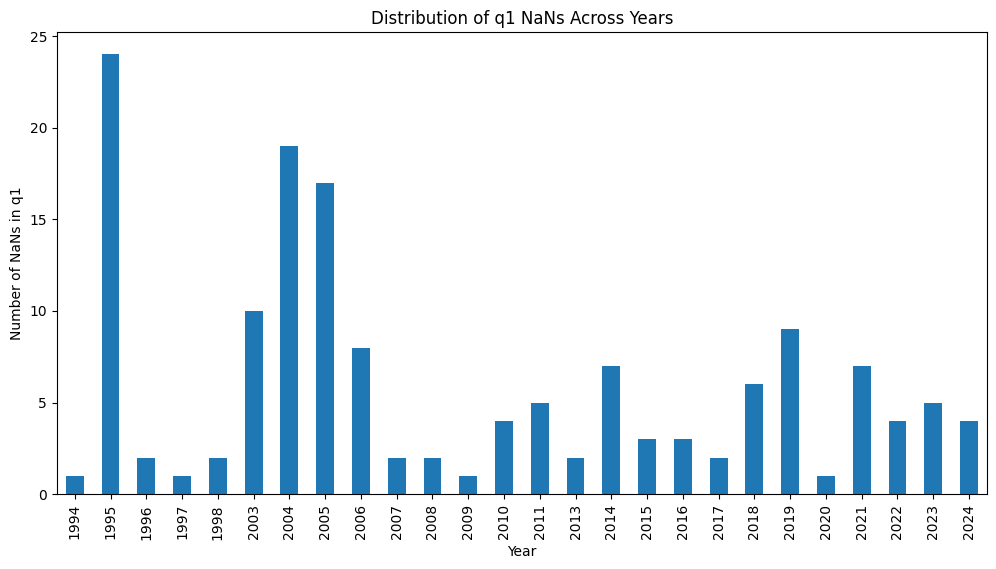

In [31]:
import matplotlib.pyplot as plt

# Count the number of NaNs in 'q1' for each year
q1_nans_per_year = merged_data[merged_data['q1'].isna()].groupby('year').size()

# Plot the results
plt.figure(figsize=(12, 6))
q1_nans_per_year.plot(kind='bar')
plt.title('Distribution of q1 NaNs Across Years')
plt.xlabel('Year')
plt.ylabel('Number of NaNs in q1')
plt.show()

veiem que els nuls estan distribuits al llarg dels anys. després d'analitzar una mica el dataset me n'he adonat que els nuls a q1 són degut a problemes mecanics o accidents dels pilots durant la classificació que fa que surtin des del pit lane (grid == 0), que després ho canviaré al darrera posició en comptes de 0, ja que sinó afecta a la correlació de les variables. 

Per tractar els nuls de q1 he fet el seguent: 

first convert q1 column to seconds. then input the missing values with the mean of the q1 for that particular race

In [32]:
def convert_to_seconds(time_str):
    if pd.isna(time_str) or time_str in ['0', '', 'N/A']:
        return np.nan
    try:
        if ':' in time_str:
            minutes, seconds = time_str.split(':')
            return int(minutes) * 60 + float(seconds)
        else:
            return float(time_str)
    except (ValueError, TypeError):
        return np.nan

In [33]:
# Count remaining NaNs in q1_seconds
merged_data['q1_seconds'] = merged_data['q1'].apply(convert_to_seconds)
num_nans = merged_data['q1_seconds'].isna().sum()
print(f"Number of NaNs in q1_seconds: {num_nans}")


Number of NaNs in q1_seconds: 151


In [34]:
# Calculate mean q1_seconds per race
mean_q1_per_race = merged_data.groupby('raceId')['q1_seconds'].transform('mean')

# Impute missing q1_seconds with race mean
merged_data['q1_seconds'] = merged_data['q1_seconds'].fillna(mean_q1_per_race)


In [35]:
# Count remaining NaNs in q1_seconds
num_nans = merged_data['q1_seconds'].isna().sum()
print(f"Number of NaNs in q1_seconds after reapplying the function: {num_nans}")

Number of NaNs in q1_seconds after reapplying the function: 24


In [36]:
# Drop rows with any remaining NaNs
merged_data.dropna(inplace=True)

# Drop the 'q1' column
merged_data.drop(columns=['q1'], inplace=True)

# Display the first few rows to confirm the changes
merged_data.head()

,raceId,year,round,circuitId,GP_name,date,circuitRef,country,grid,position,...,championship_position,number_wins,driver_dnf,constructor_dnf,driver_name,age_at_gp_in_days,driver_country,constructor_country,winner,q1_seconds
829,257,1994,1,18,Brazilian Grand Prix,1994-03-27,interlagos,Brazil,2,1,...,1,1,0,0,Michael Schumacher,9214,Germany,Italy,1,76.290
830,257,1994,1,18,Brazilian Grand Prix,1994-03-27,interlagos,Brazil,9,13,...,16,0,1,0,Jos Verstappen,8058,Netherlands,Italy,0,78.183
1525,257,1994,1,18,Brazilian Grand Prix,1994-03-27,interlagos,Brazil,4,2,...,2,0,0,0,Damon Hill,12244,UK,UK,0,77.554
1526,257,1994,1,18,Brazilian Grand Prix,1994-03-27,interlagos,Brazil,1,13,...,13,0,1,0,Ayrton Senna,12424,Brazil,UK,0,75.962
2551,257,1994,1,18,Brazilian Grand Prix,1994-03-27,interlagos,Brazil,8,13,...,21,0,0,1,Mika Häkkinen,9311,Finland,UK,0,78.122


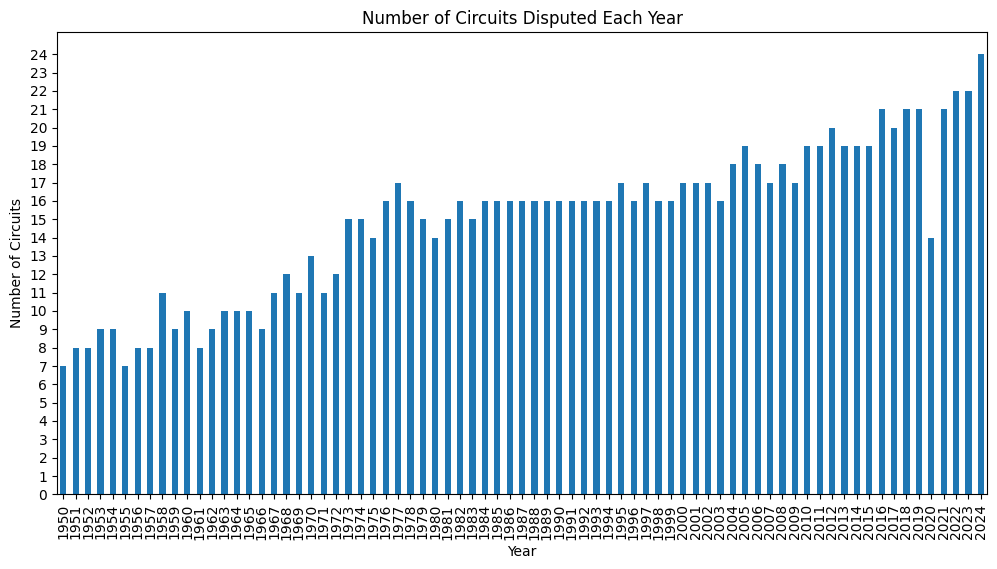

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by year and count the number of unique circuits
circuits_per_year = races.groupby('year')['circuitId'].nunique()

# Plot the results
plt.figure(figsize=(12, 6))
circuits_per_year.plot(kind='bar')
plt.title('Number of Circuits Disputed Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Circuits')
plt.yticks(range(0, int(circuits_per_year.max()) + 1))  # Set y-axis to integer values
plt.show()

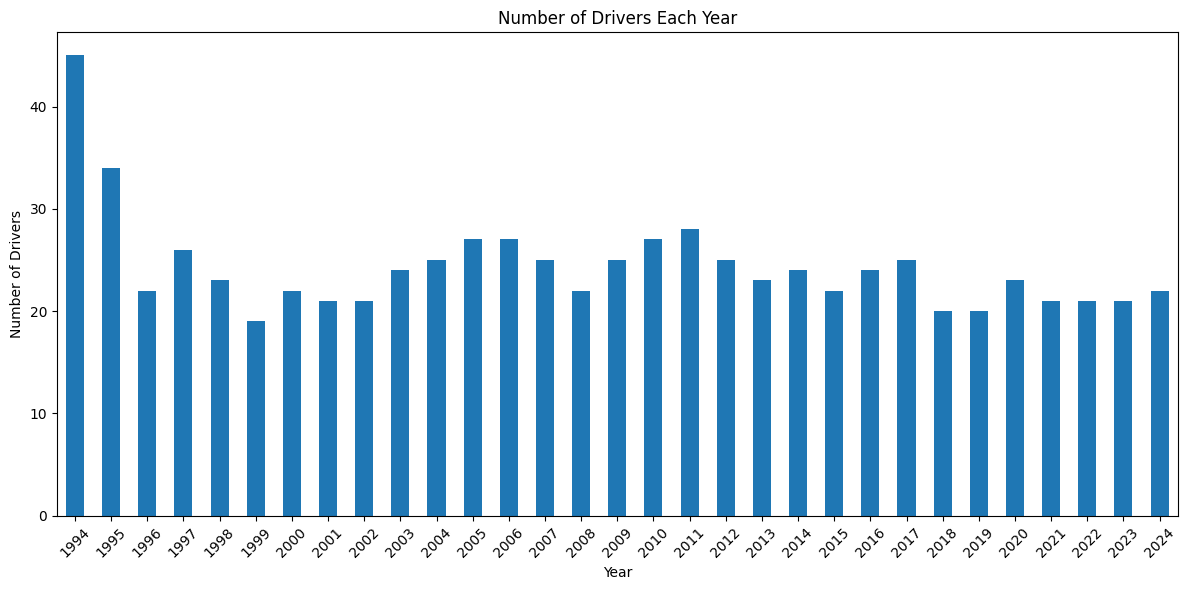

In [38]:
import matplotlib.pyplot as plt

# Group by year and count the number of unique drivers
drivers_per_year = merged_data.groupby('year')['driver_name'].nunique()

# Plot the results
plt.figure(figsize=(12, 6))
drivers_per_year.plot(kind='bar')
plt.title('Number of Drivers Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Drivers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
import matplotlib.pyplot as plt

def plot_wins_driver(results, threshold=1):
    # Your existing data manipulation steps
    winners = results[results['positionOrder'] == 1].merge(races, on='raceId')
    wins_per_driver = winners.groupby(['driverId', 'year']).size().unstack(fill_value=0)

    # Calculate total wins per driver
    total_wins_per_driver = wins_per_driver.sum(axis=1)

    # Merge with drivers to get surnames
    total_wins_per_driver = total_wins_per_driver.reset_index().merge(drivers[['driverId', 'surname']], on='driverId')

    # Filter out drivers with 0 wins
    total_wins_per_driver = total_wins_per_driver[total_wins_per_driver[0] > threshold]

    # Plot the results
    plt.figure(figsize=(15, 6))  # Increase figure size for better spacing
    ax = total_wins_per_driver.set_index('surname')[0].sort_values(ascending=False).plot(kind='bar', color='blue')

    # Rotate x-axis labels for readability
    plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees and align them to the right
    plt.title('Total Wins Per Driver')
    plt.xlabel('Driver Surname')
    plt.ylabel('Number of Wins')
    plt.grid(axis='y')

    # Adjust layout to prevent clipping of labels
    plt.tight_layout()

    # Show the plot
    plt.show()

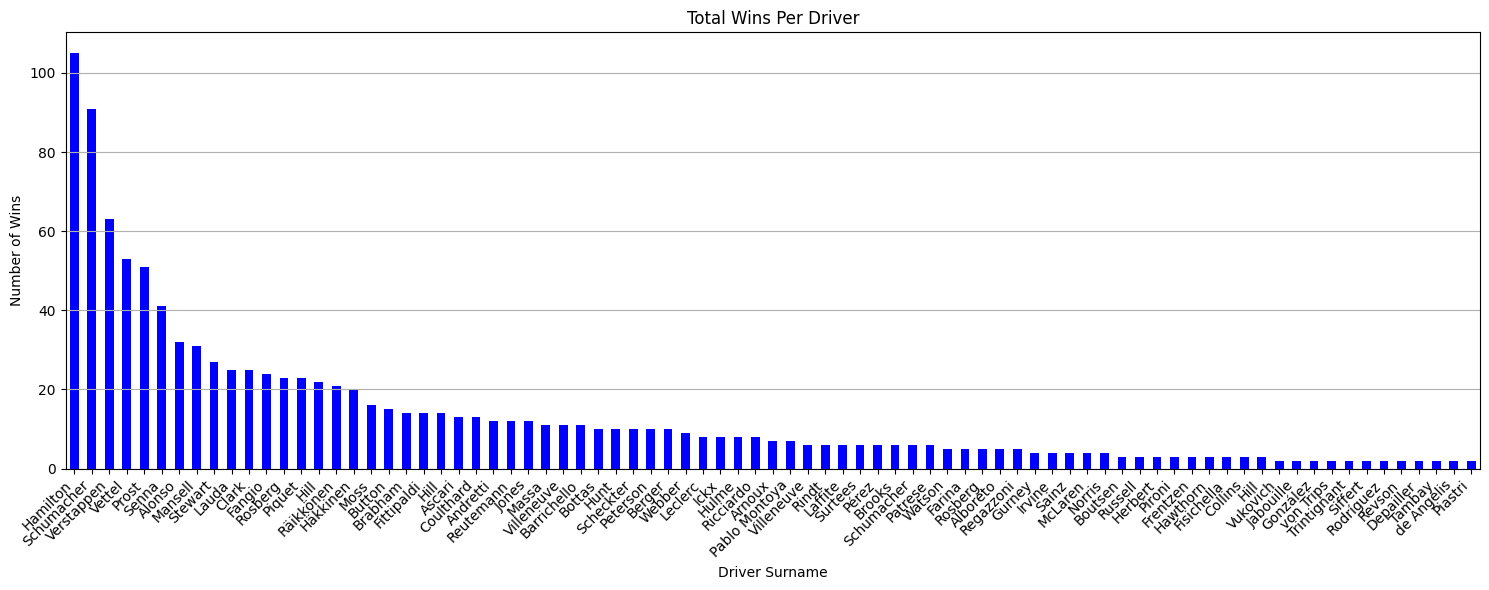

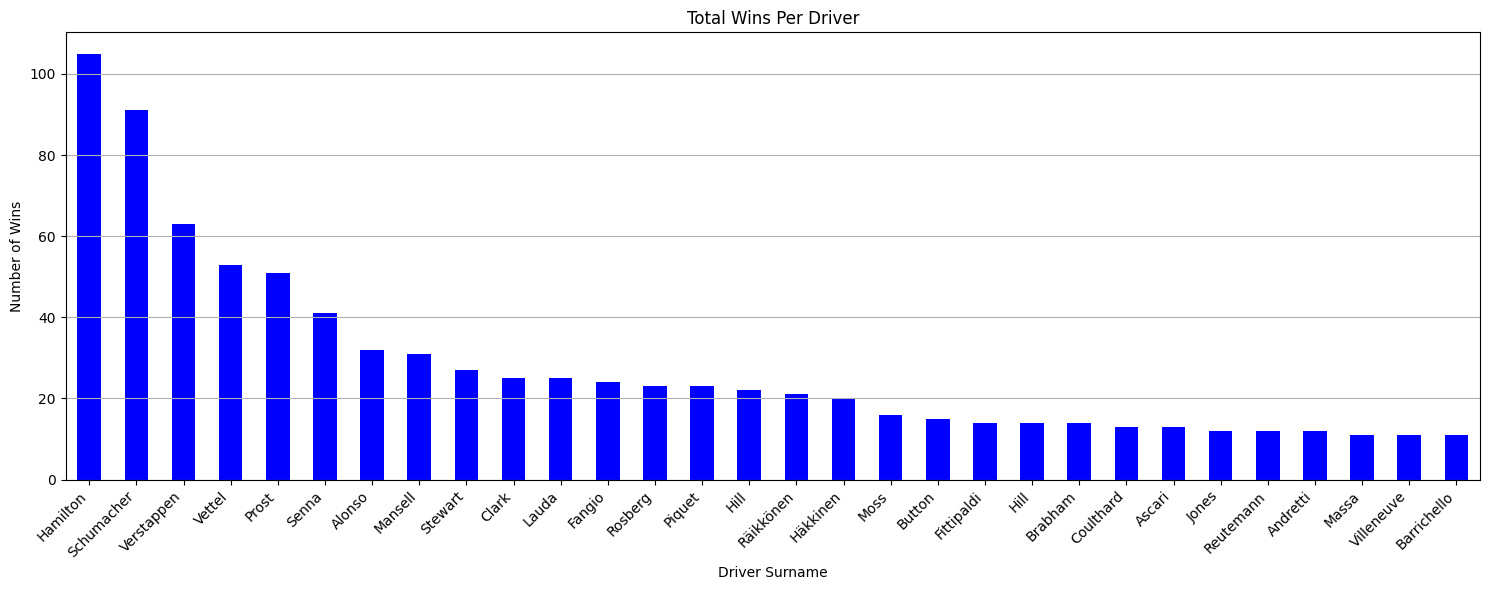

In [40]:
plot_wins_driver(results)
plot_wins_driver(results, threshold=10)

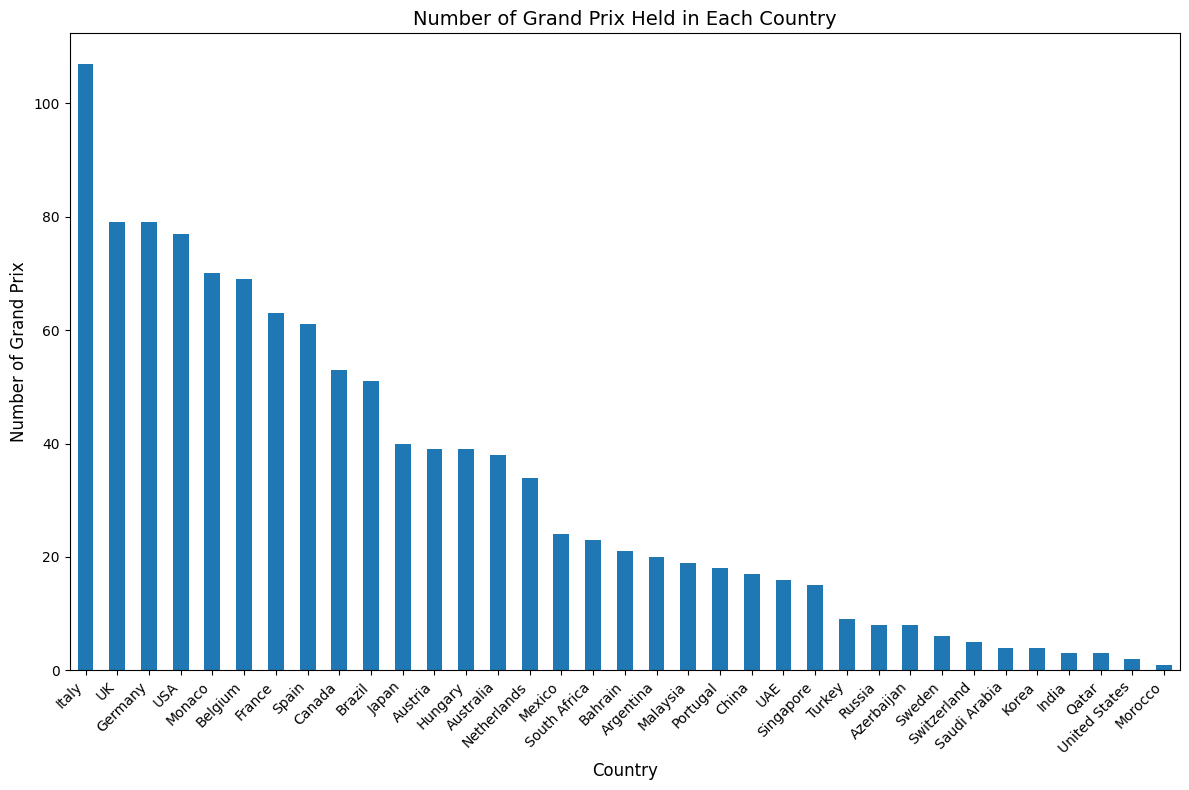

In [41]:
merged_df = pd.merge(races, circuits, left_on='circuitId', right_on='circuitId')
gp_by_country = merged_df['country'].value_counts()

# Plot the results
plt.figure(figsize=(12, 8))
gp_by_country.plot(kind='bar')
plt.title('Number of Grand Prix Held in Each Country', fontsize=14)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Grand Prix', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

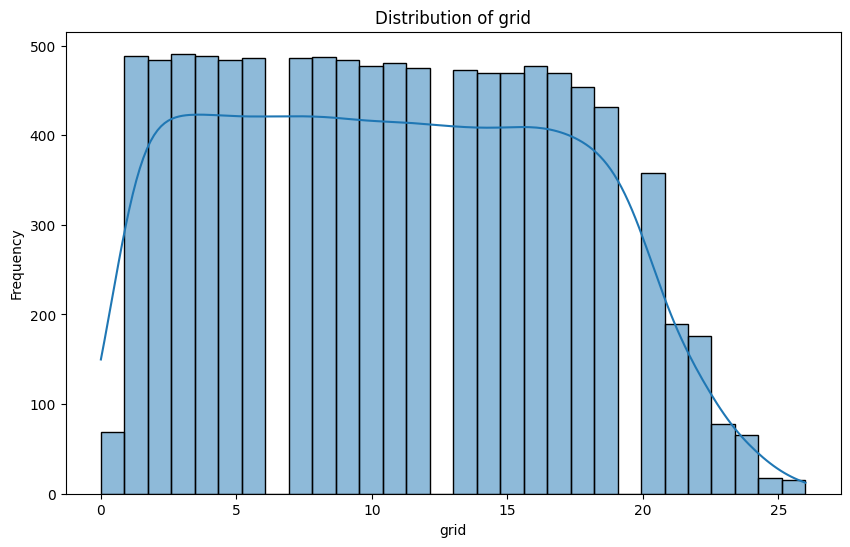

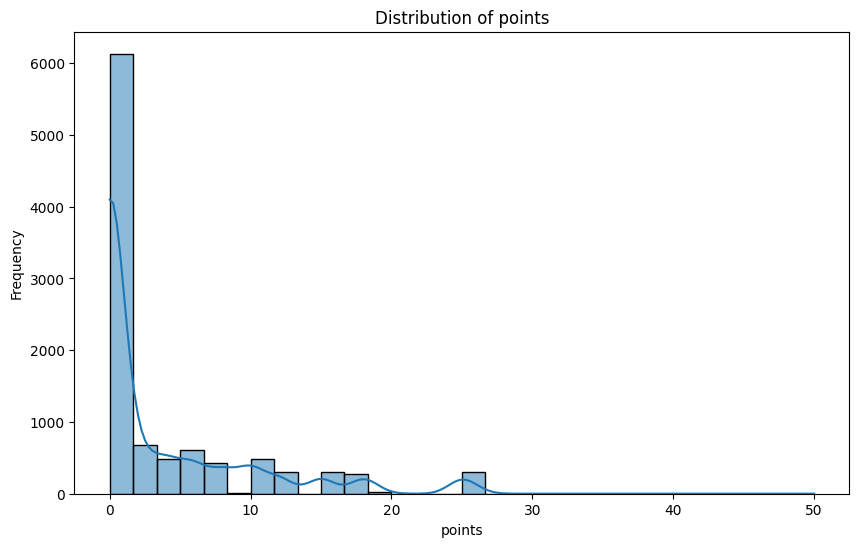

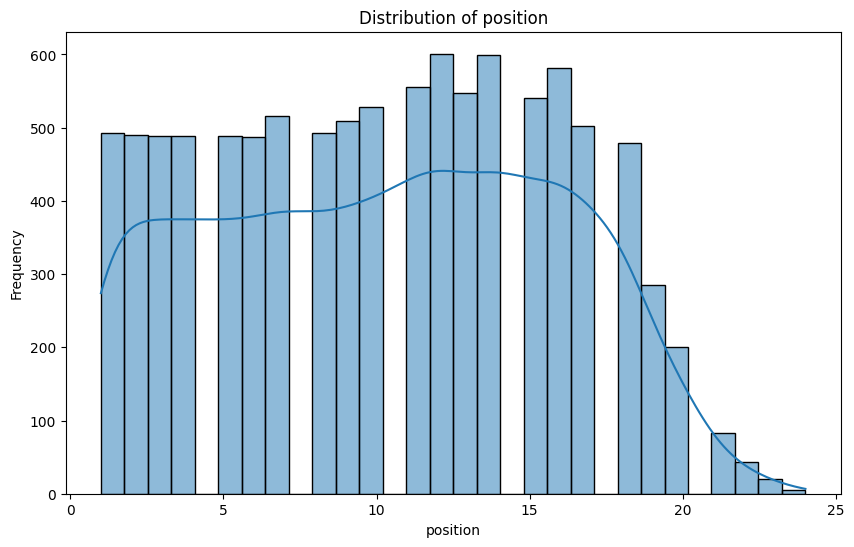

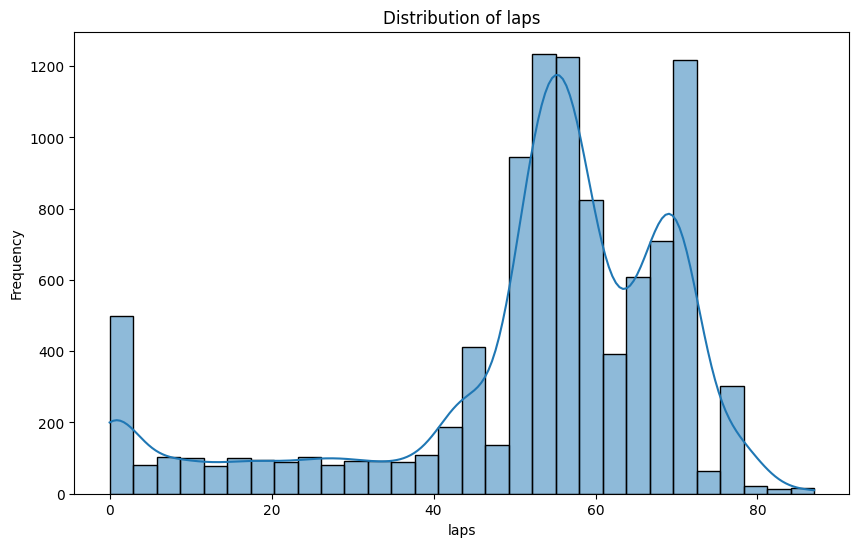

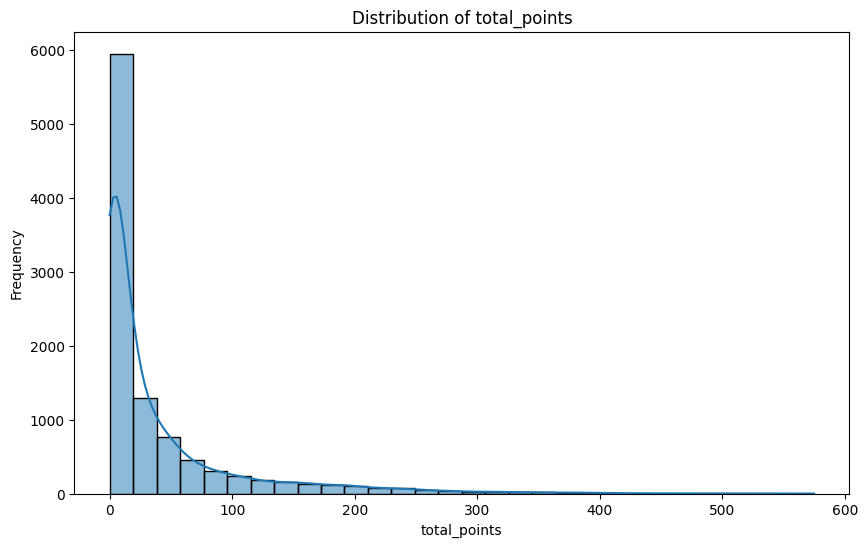

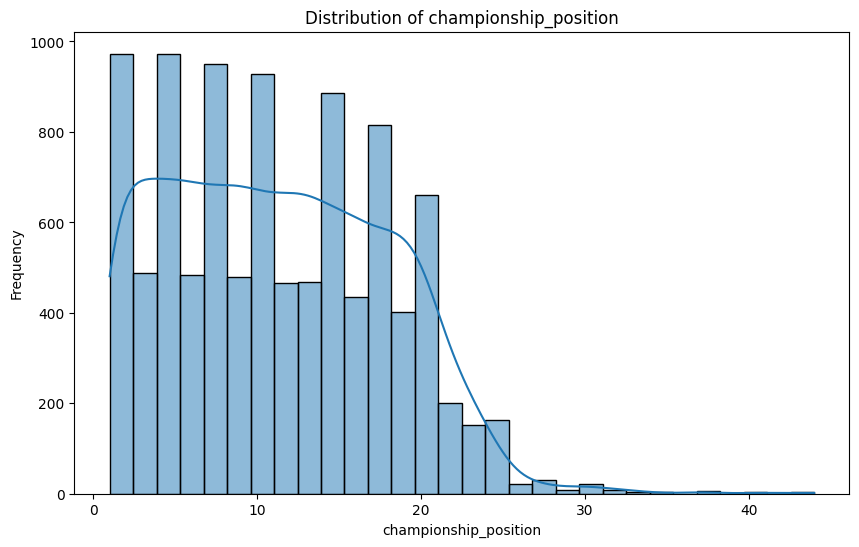

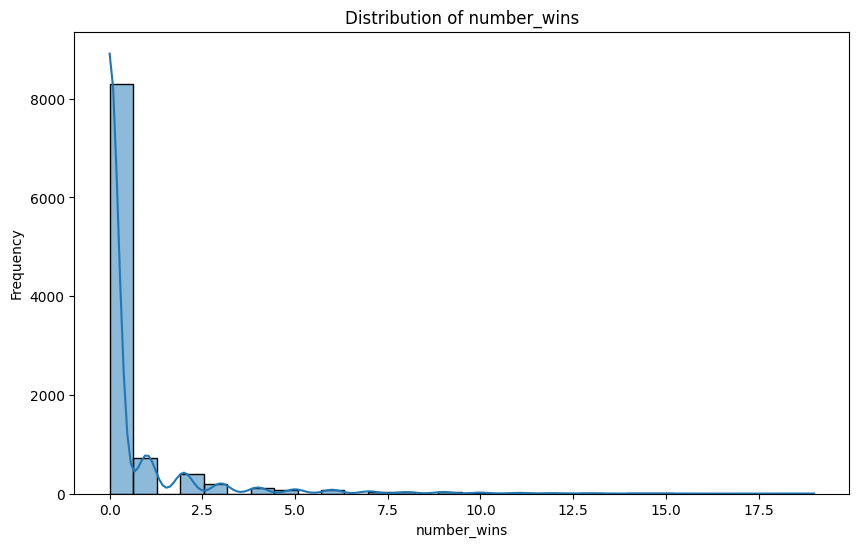

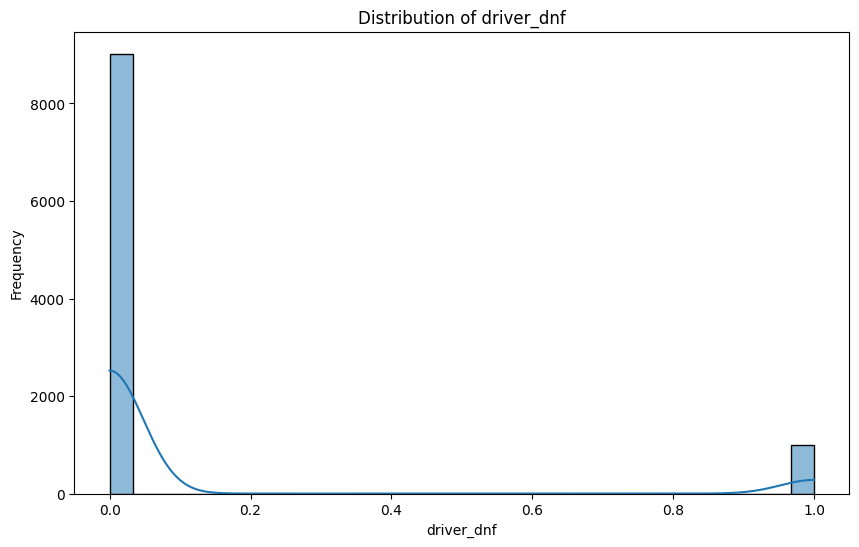

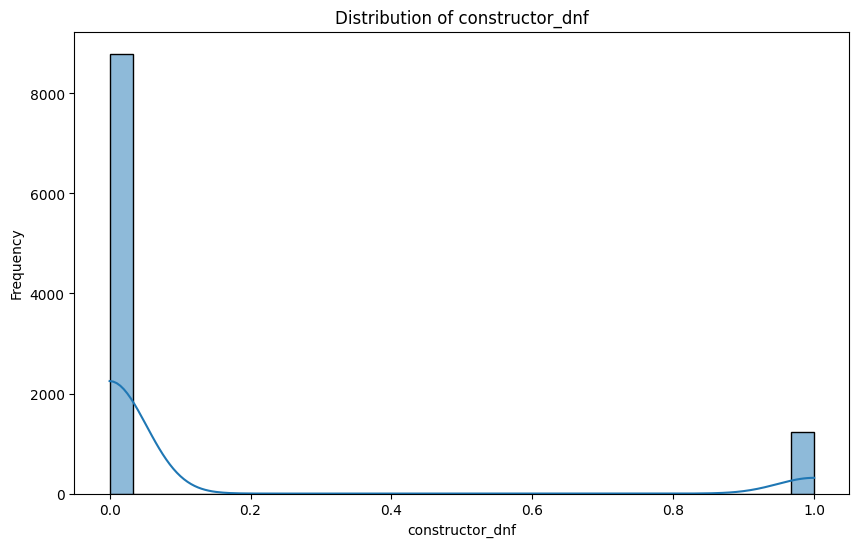

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of numerical columns to plot
numerical_columns = ['grid', 'points', 'position', 'laps', 'total_points', 'championship_position', 'number_wins', 'driver_dnf', 'constructor_dnf']

# Plot histograms and KDEs for numerical variables
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(merged_data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

C:\Users\joelc\AppData\Local\Temp\ipykernel_14968\2968168162.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = merged_data.corr()


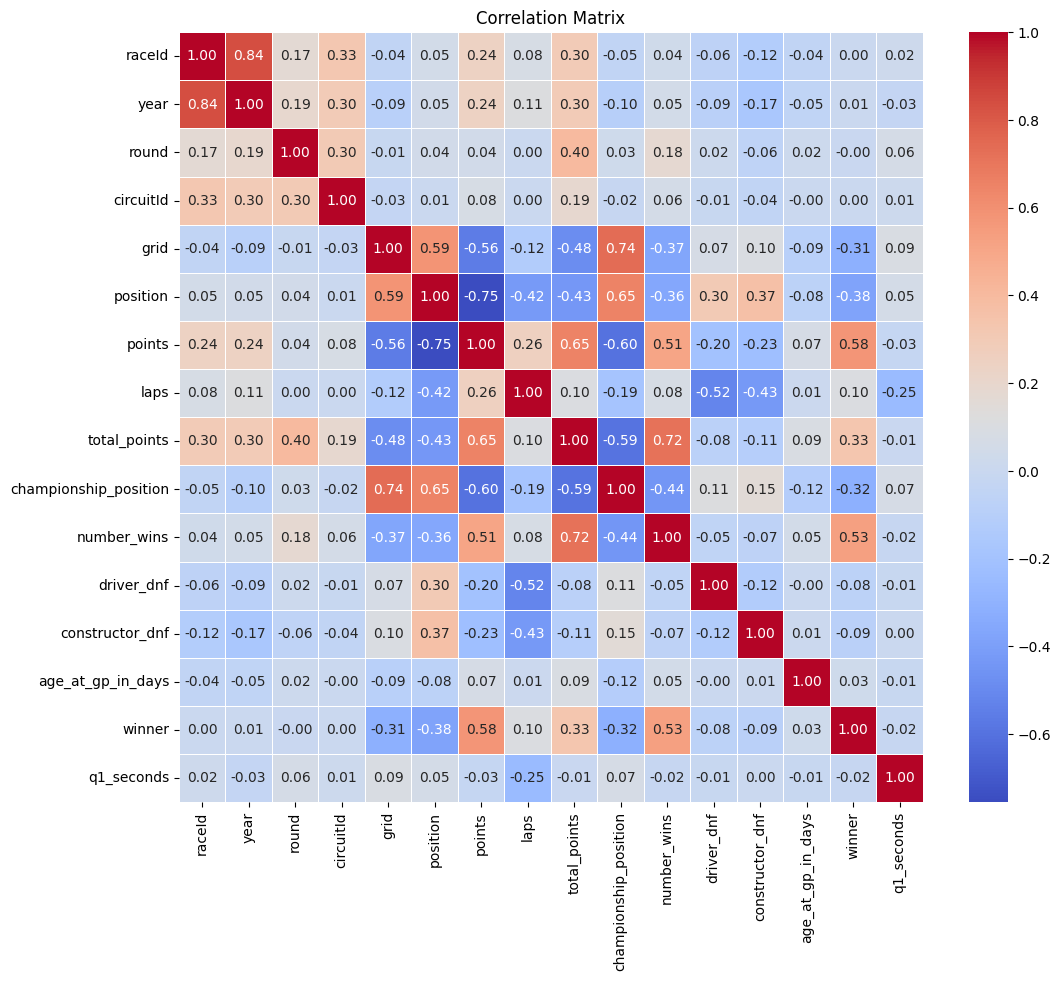

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Explore correlations between numerical variables
correlation_matrix = merged_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

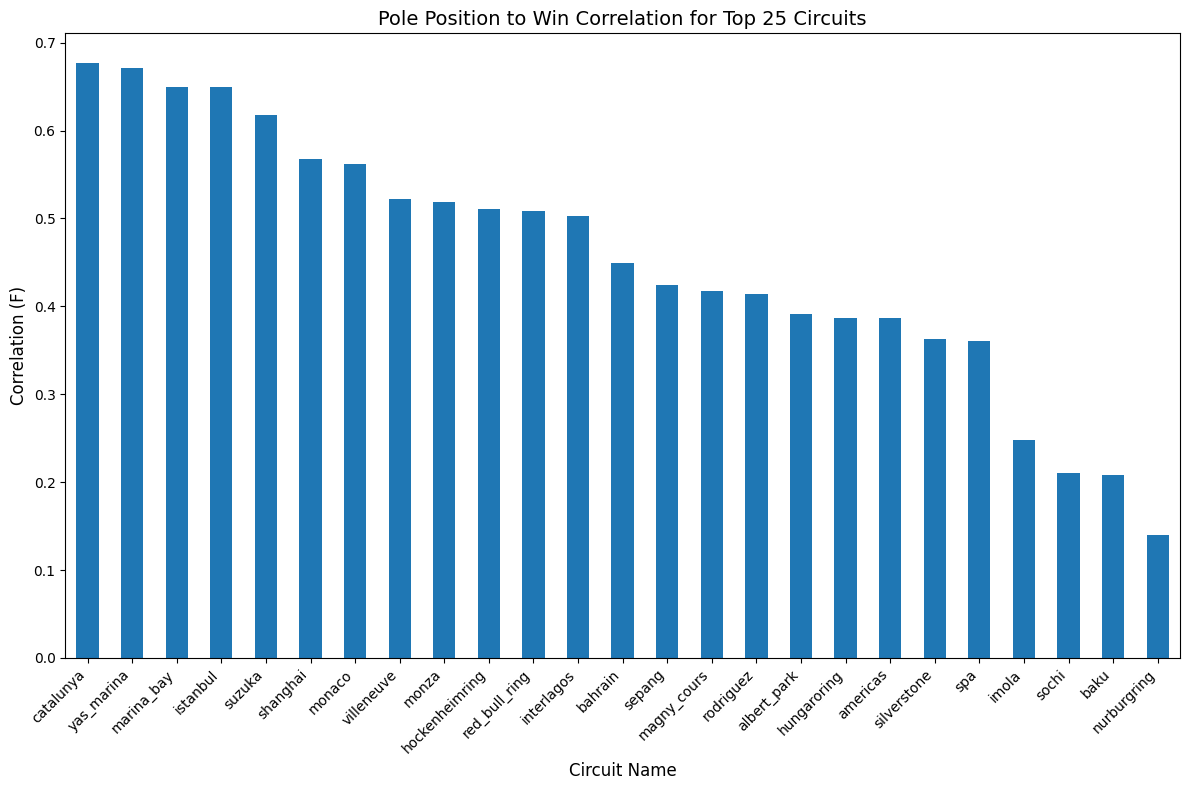

In [44]:
# Identify the 25 most popular circuits based on the number of races
top_circuits = merged_data['circuitId'].value_counts().head(25).index

# Filter the data for these circuits
filtered_data = merged_data[merged_data['circuitId'].isin(top_circuits)]

# Recalculate the correlation for these circuits
correlation_by_circuit = filtered_data.groupby('circuitId').apply(
    lambda x: x['grid'].eq(1).astype(int).corr(x['position'].eq(1).astype(int))
).sort_values(ascending=False)

# Get circuit names from the circuits data
circuit_names = circuits.set_index('circuitId')['circuitRef']

# Map circuit IDs to names for the x-axis
correlation_by_circuit.index = correlation_by_circuit.index.map(circuit_names)

# Plotting the correlation for the 15 most popular circuits
plt.figure(figsize=(12, 8))
correlation_by_circuit.plot(kind='bar')
plt.title('Pole Position to Win Correlation for Top 25 Circuits', fontsize=14)
plt.xlabel('Circuit Name', fontsize=12)
plt.ylabel('Correlation (F)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


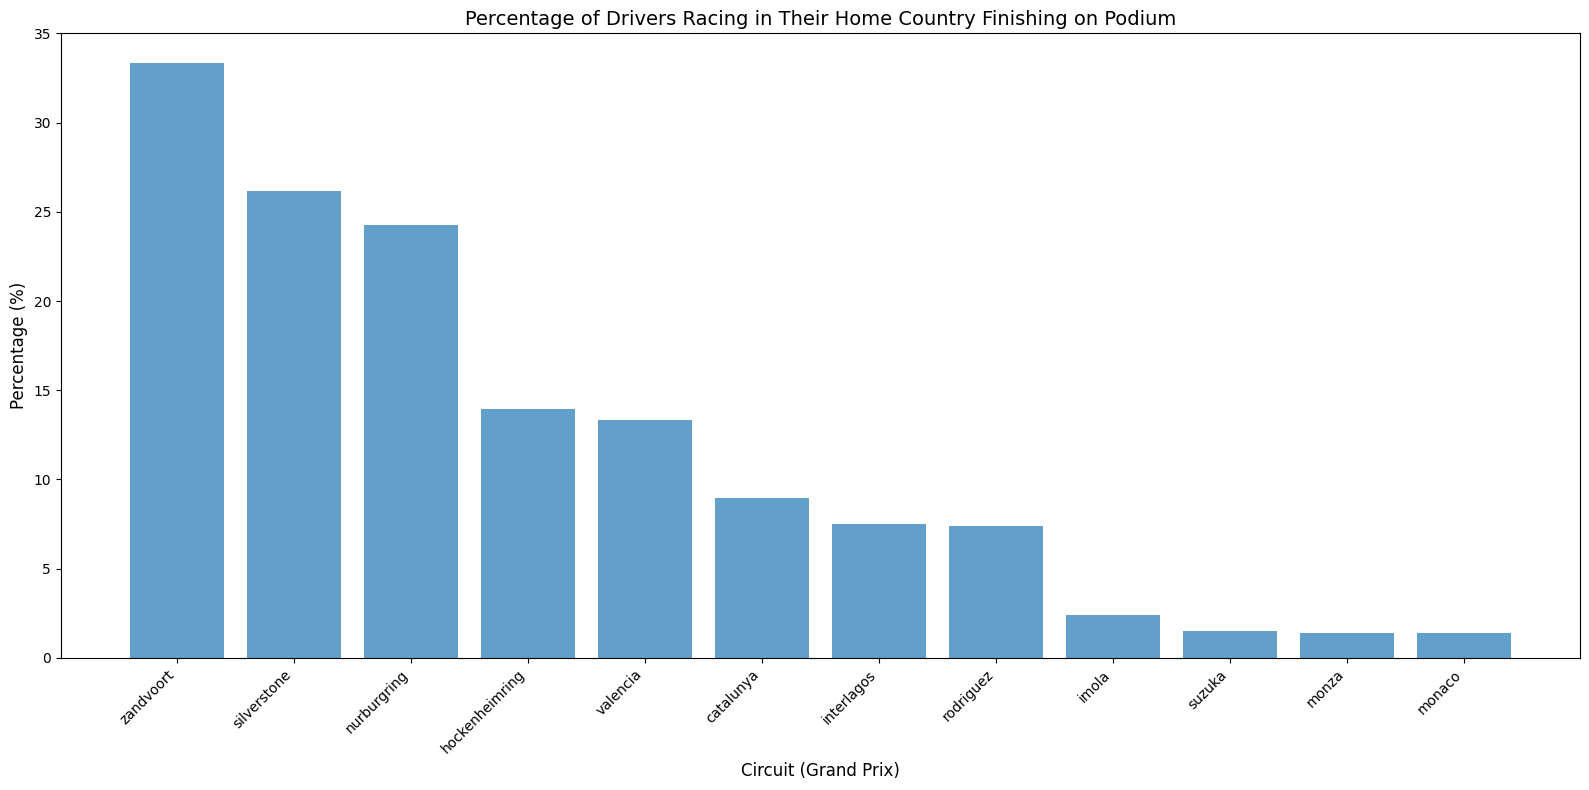

In [45]:
# Create a copy of cleaned_data
cleaned_data_df = merged_data.copy()


# Step 3: Add a column to indicate podium finishes
cleaned_data_df["on_podium"] = cleaned_data_df["position"].isin([1, 2, 3]).astype(int)

# Step 4: Calculate the percentage of podium finishes for drivers in their home country
podium_data = cleaned_data_df[cleaned_data_df["on_podium"] == 1]  # Filter podium data

# Group by circuitId and calculate the percentage of podium finishes for drivers in their home country
podium_home_circuit = (
    podium_data.apply(lambda x: x["country"] == x["driver_country"], axis=1)
    .groupby(podium_data["circuitId"])
    .mean()
    * 100
).sort_values(ascending=False)

# Merge with circuit information to get circuit names and countries
circuits_info = cleaned_data_df[["circuitId", "country", "circuitRef"]].drop_duplicates()
podium_home_circuit = podium_home_circuit.reset_index(name="percentage")
podium_home_circuit = podium_home_circuit.merge(circuits_info, on="circuitId", how="left")

# Filter to keep only circuits with percentage > 0
podium_home_circuit = podium_home_circuit[podium_home_circuit["percentage"] > 0]

# Sort by percentage and keep only necessary columns
podium_home_circuit = podium_home_circuit.sort_values(by="percentage", ascending=False)

# Plot the results
plt.figure(figsize=(16, 8))
plt.bar(
    podium_home_circuit["circuitRef"], podium_home_circuit["percentage"], alpha=0.7
)
plt.title("Percentage of Drivers Racing in Their Home Country Finishing on Podium", fontsize=14)
plt.xlabel("Circuit (Grand Prix)", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



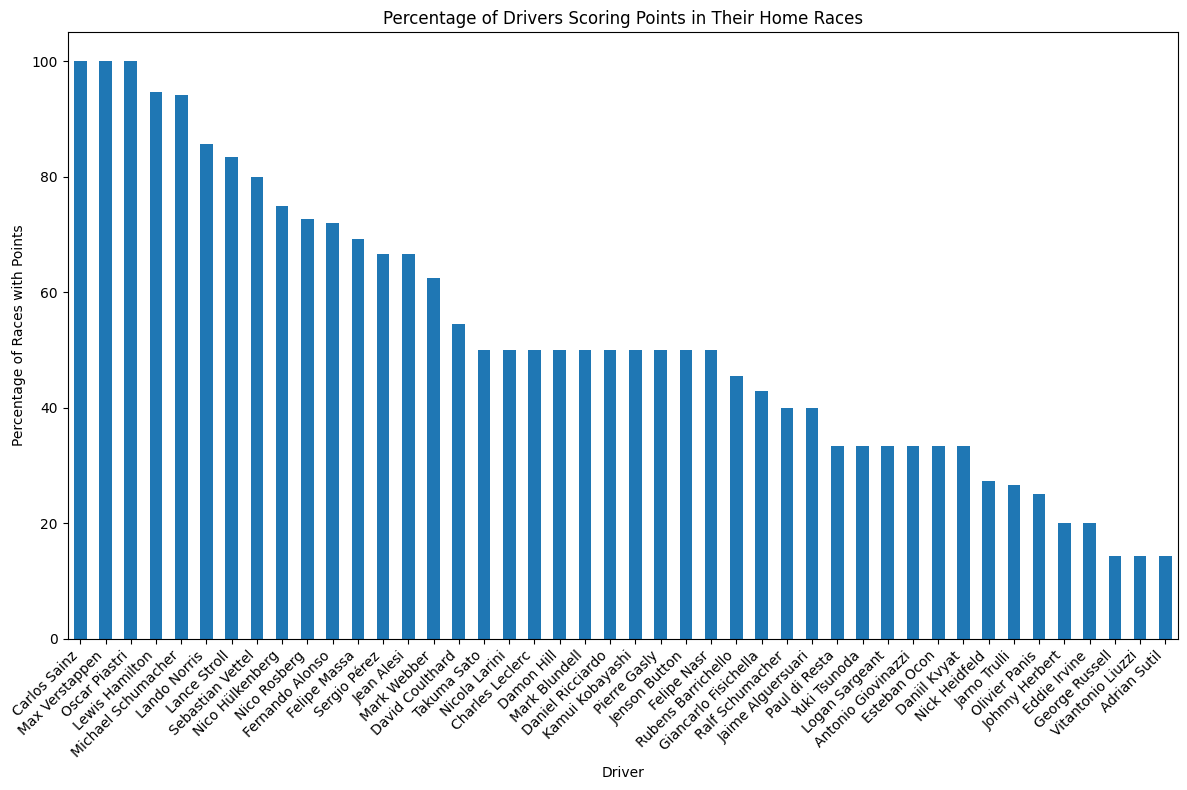

In [46]:
import matplotlib.pyplot as plt

# Filter data for drivers racing in their home country
home_race_data = cleaned_data_df[cleaned_data_df['country'] == cleaned_data_df['driver_country']]

# Calculate the percentage of races where drivers scored points in their home country
points_in_home_race = home_race_data[home_race_data['points'] > 0].groupby('driver_name').size()
total_home_races = home_race_data.groupby('driver_name').size()
points_percentage_home_race = (points_in_home_race / total_home_races) * 100

# Filter out drivers with 0% points
points_percentage_home_race = points_percentage_home_race[points_percentage_home_race > 0]

# Sort the results in descending order
points_percentage_home_race = points_percentage_home_race.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(12, 8))
points_percentage_home_race.plot(kind='bar')
plt.title('Percentage of Drivers Scoring Points in Their Home Races')
plt.xlabel('Driver')
plt.ylabel('Percentage of Races with Points')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

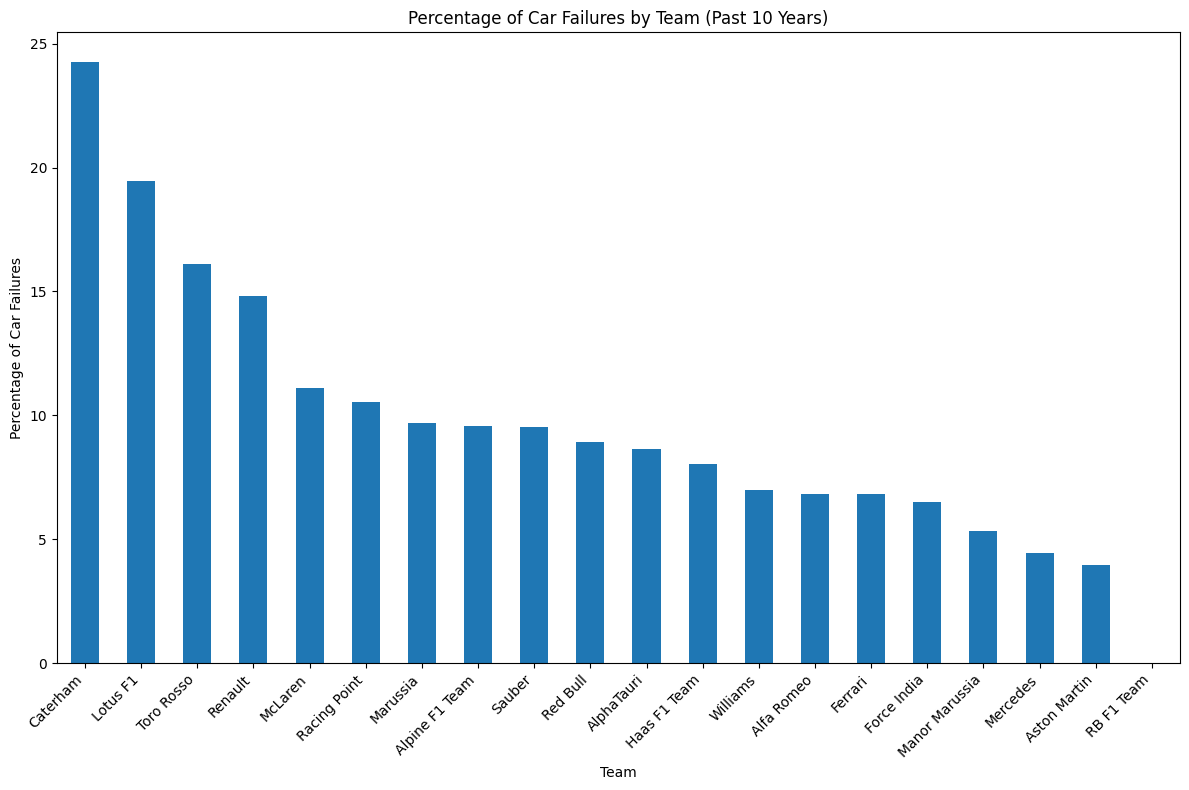

In [47]:
import matplotlib.pyplot as plt

# Filter data for the past 15 years
recent_years = merged_data[merged_data['year'] >= (merged_data['year'].max() - 10)]

# Calculate the total number of races for each team in the past 15 years
total_races_by_team_recent = recent_years['constructor_name'].value_counts()

# Calculate the number of failures for each team in the past 15 years
failures_by_team_recent = recent_years[recent_years['constructor_dnf'] == 1]['constructor_name'].value_counts()

# Calculate the percentage of failures
percentage_failures_by_team_recent = (failures_by_team_recent / total_races_by_team_recent) * 100

# Sort the results in descending order
percentage_failures_by_team_recent = percentage_failures_by_team_recent.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(12, 8))
percentage_failures_by_team_recent.plot(kind='bar')
plt.title('Percentage of Car Failures by Team (Past 10 Years)')
plt.xlabel('Team')
plt.ylabel('Percentage of Car Failures')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

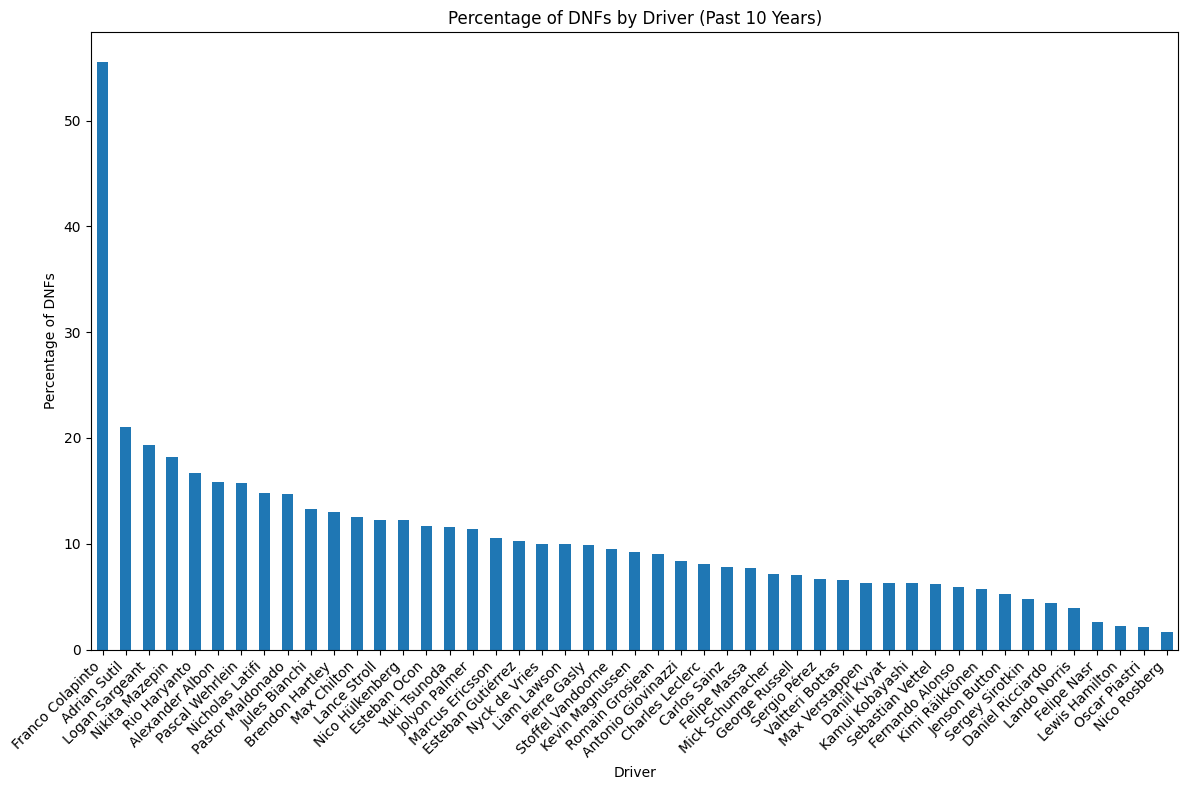

In [48]:
import matplotlib.pyplot as plt

# Filter data for the past 10 years
recent_years = merged_data[merged_data['year'] >= (merged_data['year'].max() - 10)]

# Calculate the total number of races for each driver in the past 10 years
total_races_by_driver_recent = recent_years['driver_name'].value_counts()

# Calculate the number of DNFs for each driver in the past 10 years
dnfs_by_driver_recent = recent_years[recent_years['driver_dnf'] == 1]['driver_name'].value_counts()

# Calculate the percentage of DNFs
percentage_dnfs_by_driver_recent = (dnfs_by_driver_recent / total_races_by_driver_recent) * 100

# Exclude drivers with 0 DNFs
percentage_dnfs_by_driver_recent = percentage_dnfs_by_driver_recent[percentage_dnfs_by_driver_recent > 0]

# Sort the results in descending order
percentage_dnfs_by_driver_recent = percentage_dnfs_by_driver_recent.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(12, 8))
percentage_dnfs_by_driver_recent.plot(kind='bar')
plt.title('Percentage of DNFs by Driver (Past 10 Years)')
plt.xlabel('Driver')
plt.ylabel('Percentage of DNFs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

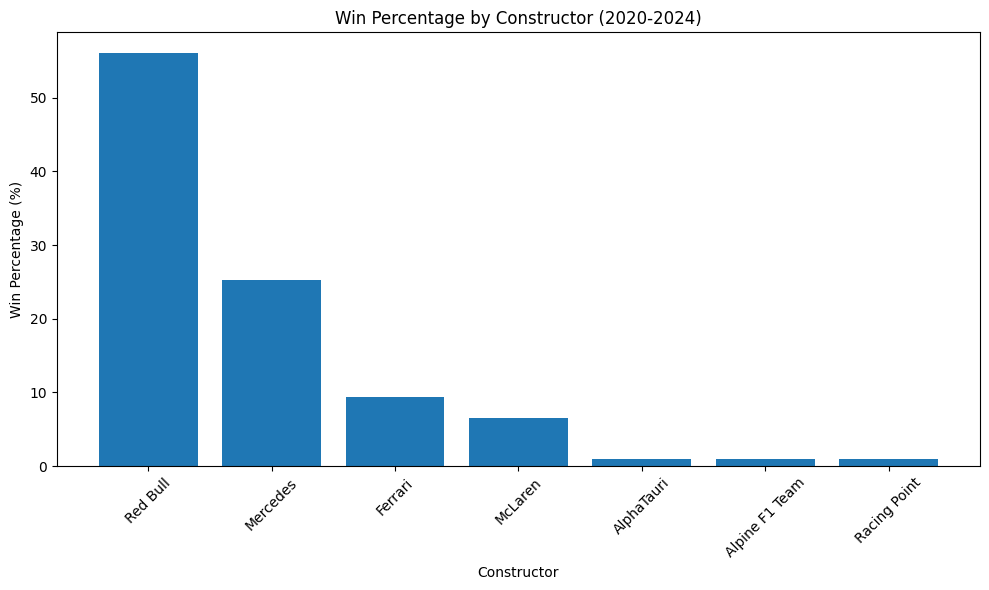

In [49]:
# Filter data for 2020 to 2024
filtered_data = merged_data[(merged_data['year'] >= 2020) & (merged_data['year'] <= 2024)]

# Group by constructor and count wins
constructor_wins = (
    filtered_data[filtered_data['winner'] == 1]
    .groupby('constructor_name')
    .size()
    .reset_index(name='wins')
)

# Calculate total wins for percentage calculation
total_wins = constructor_wins['wins'].sum()
constructor_wins['win_percentage'] = (constructor_wins['wins'] / total_wins) * 100

# Sort by number of wins in descending order
constructor_wins = constructor_wins.sort_values(by='wins', ascending=False)

#plot % of wins per team

import matplotlib.pyplot as plt

# Bar plot for the win percentage
plt.figure(figsize=(10, 6))
plt.bar(constructor_wins['constructor_name'], constructor_wins['win_percentage'])
plt.xlabel('Constructor')
plt.ylabel('Win Percentage (%)')
plt.title('Win Percentage by Constructor (2020-2024)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



C:\Users\joelc\AppData\Local\Temp\ipykernel_14968\3859285042.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winning_drivers['age_at_gp_in_years'] = winning_drivers['age_at_gp_in_days'].astype(int) / 365.25


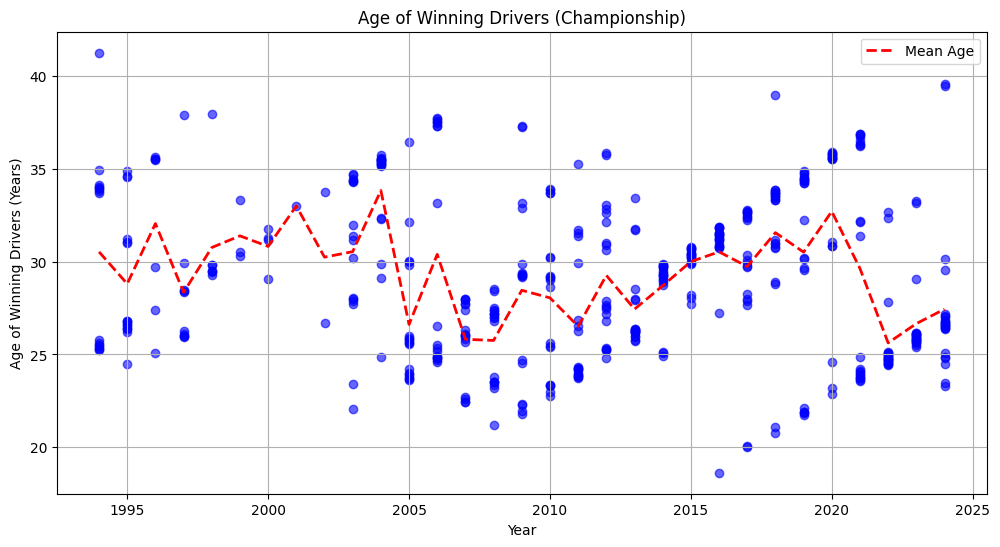

In [50]:
import matplotlib.pyplot as plt

# Filter data for winning drivers
winning_drivers = merged_data[merged_data['winner'] == 1]

# Calculate the age of the winning drivers in years
winning_drivers['age_at_gp_in_years'] = winning_drivers['age_at_gp_in_days'].astype(int) / 365.25

# Add a trending mean line
mean_age_per_year = winning_drivers.groupby('year')['age_at_gp_in_years'].mean()

plt.figure(figsize=(12, 6))
plt.scatter(winning_drivers['year'], winning_drivers['age_at_gp_in_years'], color='blue', alpha=0.6)
plt.plot(mean_age_per_year.index, mean_age_per_year.values, color='red', linestyle='--', linewidth=2, label='Mean Age')
plt.title('Age of Winning Drivers (Championship)')
plt.xlabel('Year')
plt.ylabel('Age of Winning Drivers (Years)')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
# Correcting the implementation to reset points to 0 at the beginning of each season

# Group by year and driver, then calculate cumulative sum of points within the year
merged_data['prev_points'] = merged_data.groupby(['year', 'driver_name'])['points'].cumsum() - merged_data['points']

# Calculate the championship position before the race within the same year
merged_data['prev_champ_position'] = merged_data.groupby(['year', 'round'])['championship_position'].shift(1)

# Calculate number of wins before the race within the same year
merged_data['prev_wins'] = merged_data.groupby(['year', 'round'])['number_wins'].shift(1)

# Fill NaN values for the first race of the season
merged_data['prev_points'] = merged_data['prev_points'].fillna(0)
merged_data['prev_champ_position'] = merged_data['prev_champ_position'].fillna(0).astype(int)
merged_data['prev_wins'] = merged_data['prev_wins'].fillna(0).astype(int)



merged_data.head()


,raceId,year,round,circuitId,GP_name,date,circuitRef,country,grid,position,...,constructor_dnf,driver_name,age_at_gp_in_days,driver_country,constructor_country,winner,q1_seconds,prev_points,prev_champ_position,prev_wins
829,257,1994,1,18,Brazilian Grand Prix,1994-03-27,interlagos,Brazil,2,1,...,0,Michael Schumacher,9214,Germany,Italy,1,76.290,0.0,0,0
830,257,1994,1,18,Brazilian Grand Prix,1994-03-27,interlagos,Brazil,9,13,...,0,Jos Verstappen,8058,Netherlands,Italy,0,78.183,0.0,1,1
1525,257,1994,1,18,Brazilian Grand Prix,1994-03-27,interlagos,Brazil,4,2,...,0,Damon Hill,12244,UK,UK,0,77.554,0.0,16,0
1526,257,1994,1,18,Brazilian Grand Prix,1994-03-27,interlagos,Brazil,1,13,...,0,Ayrton Senna,12424,Brazil,UK,0,75.962,0.0,2,0
2551,257,1994,1,18,Brazilian Grand Prix,1994-03-27,interlagos,Brazil,8,13,...,1,Mika Häkkinen,9311,Finland,UK,0,78.122,0.0,13,0


In [52]:
merged_data.to_csv('data/cleaned_data_EDA.csv', index=False)

### First training

initial prediction to evaluate the model's performance before proceeding with feature engineering and hyperparameter tuning.

Understanding the Problem
Objective: For each race, predict which driver will win (i.e., finish in position 1).
Constraints:
Only one driver can win each race.
Multiple drivers participate in each race.
Classification vs. Regression
Classification Problem:

Involves predicting a discrete class label.
Binary Classification: Predict whether each driver will win (1) or not (0).
Multiclass Classification: Not applicable here since only one driver wins per race.
Regression Problem:

Involves predicting a continuous value.
Predicting Positions: Could predict the finishing position of each driver (1st, 2nd, 3rd, etc.).
Answer: It's Primarily a Classification Problem with a Ranking Component
Classification:

Since the outcome (winning or not) is categorical, it's a classification problem.
However, due to the nature of the problem (only one winner per race), we need to handle it carefully.
Ranking Component:

We need to rank drivers within each race to predict the most likely winner.
This adds a layer of complexity beyond simple binary classification.
How to Proceed
1. Set Up the Problem as a Classification Task
Goal: For each driver in each race, predict the probability of winning.
Target Variable: winner (1 if the driver won the race, 0 otherwise).
2. Address the Unique Challenge
Constraint: Only one driver can win per race.
Implication: Traditional classification might predict multiple winners per race, which isn't realistic.
3. Implement a Per-Race Winner Selection
Solution: For each race, after predicting probabilities, select the driver with the highest probability as the predicted winner.
This ensures that only one driver is predicted as the winner per race.

In [53]:
import pandas as pd

# Read the data with error handling

data = pd.read_csv('data/cleaned_data_EDA.csv')
print(data.head())


   raceId  year  round  circuitId               GP_name        date  \
0     257  1994      1         18  Brazilian Grand Prix  1994-03-27   
1     257  1994      1         18  Brazilian Grand Prix  1994-03-27   
2     257  1994      1         18  Brazilian Grand Prix  1994-03-27   
3     257  1994      1         18  Brazilian Grand Prix  1994-03-27   
4     257  1994      1         18  Brazilian Grand Prix  1994-03-27   

   circuitRef country  grid  position  ...  constructor_dnf  \
0  interlagos  Brazil     2         1  ...                0   
1  interlagos  Brazil     9        13  ...                0   
2  interlagos  Brazil     4         2  ...                0   
3  interlagos  Brazil     1        13  ...                0   
4  interlagos  Brazil     8        13  ...                1   

          driver_name age_at_gp_in_days driver_country  constructor_country  \
0  Michael Schumacher              9214        Germany                Italy   
1      Jos Verstappen              8

In [54]:
# Check data types
print(data.dtypes)

raceId                     int64
year                       int64
round                      int64
circuitId                  int64
GP_name                   object
date                      object
circuitRef                object
country                   object
grid                       int64
position                   int64
points                   float64
laps                       int64
dob                       object
constructor_name          object
total_points             float64
championship_position      int64
number_wins                int64
driver_dnf                 int64
constructor_dnf            int64
driver_name               object
age_at_gp_in_days          int64
driver_country            object
constructor_country       object
winner                     int64
q1_seconds               float64
prev_points              float64
prev_champ_position        int64
prev_wins                  int64
dtype: object


In [55]:
data.columns

Index(['raceId', 'year', 'round', 'circuitId', 'GP_name', 'date', 'circuitRef',
       'country', 'grid', 'position', 'points', 'laps', 'dob',
       'constructor_name', 'total_points', 'championship_position',
       'number_wins', 'driver_dnf', 'constructor_dnf', 'driver_name',
       'age_at_gp_in_days', 'driver_country', 'constructor_country', 'winner',
       'q1_seconds', 'prev_points', 'prev_champ_position', 'prev_wins'],
      dtype='object')

In [62]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('data/cleaned_data_EDA.csv')


# Select features and target
features = [
    'grid', 'age_at_gp_in_days', 'q1_seconds', 'prev_points', 'prev_champ_position', 'circuitRef', 'round', 
    'prev_wins', 'driver_country', 'constructor_name', 'country', 'constructor_country', 'driver_name', 'year'

]

target = 'winner'

# Subset the data
df = data[features + ['raceId', target]].copy()


# Define categorical and numerical features
categorical_features = ['driver_country', 'constructor_name', 'country', 'constructor_country', 'driver_name', 'circuitRef']
numerical_features_to_scale = ['age_at_gp_in_days', 'q1_seconds', 'year']
numerical_features_unscaled = [
    'grid', 'prev_points', 'prev_champ_position', 'prev_wins', 'round'
]

# Split data into training and test sets based on year
train_df = df[df['year'] < 2020].reset_index(drop=True)
test_df = df[df['year'] >= 2020].reset_index(drop=True)

# Prepare training data
X_train = train_df[features]
y_train = train_df[target]

# Prepare test data
X_test = test_df[features]
y_test = test_df[target]
race_ids_test = test_df['raceId']
driver_names_test = test_df['driver_name']

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaled', StandardScaler(), numerical_features_to_scale),
        ('num_unscaled', 'passthrough', numerical_features_unscaled),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Function to calculate race-wise accuracy
def calculate_race_wise_accuracy(y_true, y_probs, race_ids, driver_names):
    # Create a DataFrame with the necessary information
    results_df = pd.DataFrame({
        'raceId': race_ids,
        'driver_name': driver_names,
        'winner': y_true,
        'predicted_prob': y_probs
    })

    # Get unique races
    unique_races = results_df['raceId'].unique()
    
    correct_predictions = 0
    total_races = len(unique_races)

    for race_id in unique_races:
        race_data = results_df[results_df['raceId'] == race_id]
        # Predict the winner as the driver with the highest predicted probability
        predicted_winner = race_data.loc[race_data['predicted_prob'].idxmax()]
        actual_winner = race_data[race_data['winner'] == 1]
        if not actual_winner.empty:
            actual_winner_name = actual_winner['driver_name'].values[0]
            if predicted_winner['driver_name'] == actual_winner_name:
                correct_predictions += 1
        else:
            # Handle cases where there is no actual winner in the data
            total_races -= 1  # Exclude this race from total count
    if total_races > 0:
        race_wise_accuracy = correct_predictions / total_races
    else:
        race_wise_accuracy = 0
    return race_wise_accuracy


# Create a function to perform cross-validation and calculate mean race-wise accuracy
def cross_validate_race_wise(model, X, y, df, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    race_wise_accuracies = []

    for train_index, val_index in tscv.split(X):
        X_train_fold = X.iloc[train_index]
        y_train_fold = y.iloc[train_index]
        X_val_fold = X.iloc[val_index]
        y_val_fold = y.iloc[val_index]
        df_val_fold = df.iloc[val_index].reset_index(drop=True)
        
        # Create pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        # Fit the model
        pipeline.fit(X_train_fold, y_train_fold)
        
        # Predict probabilities on validation set
        y_probs = pipeline.predict_proba(X_val_fold)[:, 1]
        
        # Calculate race-wise accuracy
        race_wise_acc = calculate_race_wise_accuracy(
            y_true=y_val_fold.reset_index(drop=True),
            y_probs=y_probs,
            race_ids=df_val_fold['raceId'],
            driver_names=df_val_fold['driver_name']
        )
        race_wise_accuracies.append(race_wise_acc)

    mean_race_wise_accuracy = np.mean(race_wise_accuracies)
    return mean_race_wise_accuracy

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Adjust scale_pos_weight for XGBoost
ratio = (len(y_train) - sum(y_train)) / sum(y_train)
models['XGBoost'].set_params(scale_pos_weight=ratio)

# Store results
results = {}

for model_name, model in models.items():
    print(f"Processing {model_name}...")
    # Cross-validation on training data
    mean_race_wise_accuracy = cross_validate_race_wise(model, X_train, y_train, train_df, n_splits=5)
    
    # Fit the model on the entire training data
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    
    # Predict probabilities on test data
    y_probs_test = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate race-wise accuracy on test set
    test_race_wise_accuracy = calculate_race_wise_accuracy(
        y_true=y_test.reset_index(drop=True),
        y_probs=y_probs_test,
        race_ids=race_ids_test.reset_index(drop=True),
        driver_names=driver_names_test.reset_index(drop=True)
    )
    
    # Store the results
    results[model_name] = {
        'mean_race_wise_accuracy_train': mean_race_wise_accuracy,
        'race_wise_accuracy_test': test_race_wise_accuracy
    }

# Print summary of results
print("\nSummary of Results:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f" - Mean Race-wise Accuracy on training data: {metrics['mean_race_wise_accuracy_train']:.4f}")
    print(f" - Race-wise Accuracy on test data: {metrics['race_wise_accuracy_test']:.4f}\n")


Processing Logistic Regression...
Processing Random Forest...
Processing SVM...
Processing XGBoost...

Summary of Results:
Logistic Regression:
 - Mean Race-wise Accuracy on training data: 0.3936
 - Race-wise Accuracy on test data: 0.5234

Random Forest:
 - Mean Race-wise Accuracy on training data: 0.3870
 - Race-wise Accuracy on test data: 0.4579

SVM:
 - Mean Race-wise Accuracy on training data: 0.3719
 - Race-wise Accuracy on test data: 0.4860

XGBoost:
 - Mean Race-wise Accuracy on training data: 0.4276
 - Race-wise Accuracy on test data: 0.4579



In [ ]:
# Predict probabilities on the test set
y_probs_test_xgb = pipeline.predict_proba(X_test)[:, 1]

# Create a copy of the test DataFrame and add predicted probabilities
results_xgb = test_df.copy()
results_xgb['proba_1'] = y_probs_test_xgb
results_xgb['proba_0'] = 1 - results_xgb['proba_1']
results_xgb['actual'] = results_xgb['winner']  # Actual winner (0/1)

# For each race, find the driver with the highest probability of winning
predicted_winners = []
for rid in results_xgb['raceId'].unique():
    race_data = results_xgb[results_xgb['raceId'] == rid]
    # Get the index of the driver with the highest predicted probability
    winner_idx = race_data['proba_1'].idxmax()
    predicted_winners.append(winner_idx)

# Create a set of predicted winner indices for quick membership checking
predicted_winner_indices = set(predicted_winners)

# Add a 'predicted' column (1 if predicted winner, else 0)
results_xgb['predicted'] = results_xgb.index.map(lambda i: 1 if i in predicted_winner_indices else 0)

# Select the columns to display
# If you have a 'podium' column or want to add more info, do so similarly.
display_columns = ['driver_name', 'proba_0', 'proba_1', 'actual', 'predicted']

# Sort and take a look at the head (You can adjust sorting logic as you prefer)
final_display = results_xgb[display_columns].head(10)

print(final_display)


        driver_name   proba_0   proba_1  actual  predicted
0  Daniel Ricciardo  0.999970  0.000030       0          0
1      Esteban Ocon  0.999718  0.000282       0          0
2    George Russell  0.999819  0.000181       0          0
3   Nicholas Latifi  0.999938  0.000062       0          0
4      Carlos Sainz  0.999176  0.000824       0          0
5      Lando Norris  0.861821  0.138179       0          0
6  Sebastian Vettel  0.999555  0.000445       0          0
7   Charles Leclerc  0.997863  0.002137       0          0
8    Lewis Hamilton  0.993240  0.006760       0          0
9   Valtteri Bottas  0.692565  0.307435       1          1


In [64]:
# Let's pick one race to inspect. For example, we can take the first race from the test set.
example_race_id = results_xgb['raceId'].iloc[0]

# Filter the DataFrame to include only that race
race_data = results_xgb[results_xgb['raceId'] == example_race_id].copy()

# Sort the race_data by proba_1 in descending order (highest probability first)
race_data_sorted = race_data.sort_values(by='proba_1', ascending=False)

# Select columns to display
columns_to_display = ['driver_name', 'proba_0', 'proba_1', 'actual', 'predicted']

# Display the sorted DataFrame for this race
print(race_data_sorted[columns_to_display])


           driver_name   proba_0   proba_1  actual  predicted
9      Valtteri Bottas  0.692565  0.307435       1          1
10      Max Verstappen  0.848243  0.151757       0          0
5         Lando Norris  0.861821  0.138179       0          0
11     Alexander Albon  0.924140  0.075860       0          0
8       Lewis Hamilton  0.993240  0.006760       0          0
16        Sergio Pérez  0.995918  0.004082       0          0
7      Charles Leclerc  0.997863  0.002137       0          0
4         Carlos Sainz  0.999176  0.000824       0          0
6     Sebastian Vettel  0.999555  0.000445       0          0
18        Daniil Kvyat  0.999653  0.000347       0          0
1         Esteban Ocon  0.999718  0.000282       0          0
2       George Russell  0.999819  0.000181       0          0
19        Pierre Gasly  0.999822  0.000178       0          0
15     Kevin Magnussen  0.999936  0.000064       0          0
3      Nicholas Latifi  0.999938  0.000062       0          0
14     R

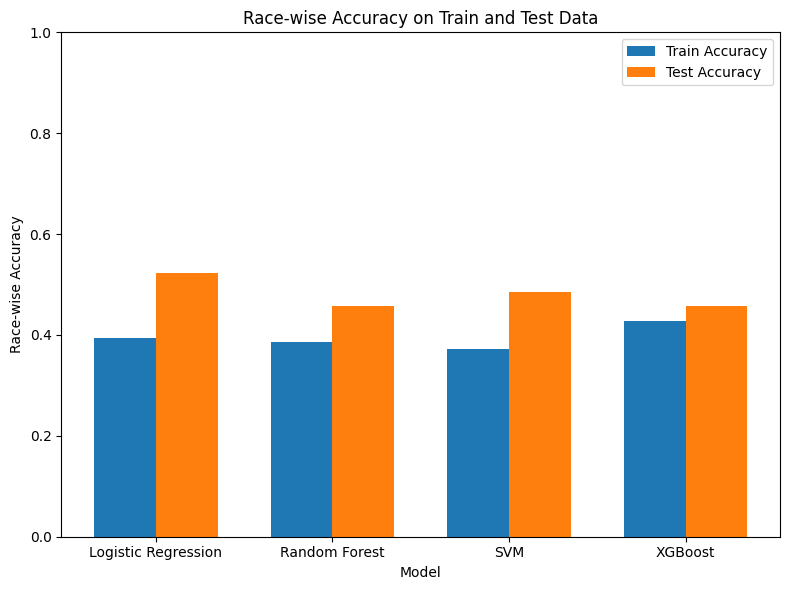

In [171]:
import numpy as np

import matplotlib.pyplot as plt

# Data
models = ['Logistic Regression', 'Random Forest', 'SVM', 'XGBoost']
mean_race_wise_accuracy_train = [0.3936, 0.3870, 0.3719, 0.4276]
race_wise_accuracy_test = [0.5234, 0.4579, 0.4860, 0.4579]

# Plotting
x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, mean_race_wise_accuracy_train, width, label='Train Accuracy')
rects2 = ax.bar(x + width/2, race_wise_accuracy_test, width, label='Test Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Model')
ax.set_ylabel('Race-wise Accuracy')
ax.set_title('Race-wise Accuracy on Train and Test Data')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()



fig.tight_layout()

plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.show()

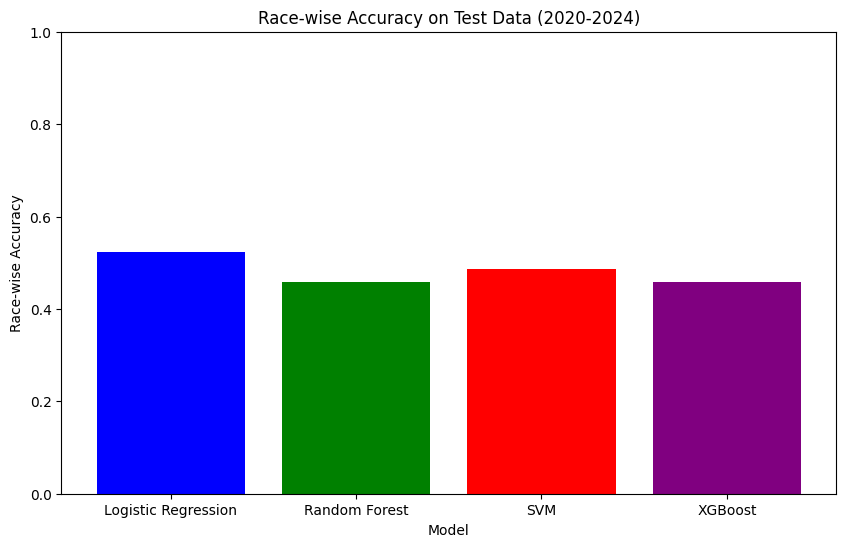

In [98]:
import matplotlib.pyplot as plt

# Extract race-wise accuracy on test data for each model
model_names = list(results.keys())
race_wise_accuracies = [results[model]['race_wise_accuracy_test'] for model in model_names]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, race_wise_accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Race-wise Accuracy')
plt.title('Race-wise Accuracy on Test Data (2020-2024)')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.show()

### FEATURE ENGINEERING

new features: 
- constructor reliability
- driver reliability
- driver home race
- constructor hom race
- average performance last 3 races

In [68]:
def calculate_constructor_reliability(df):
    # Calculate total races participated by each constructor
    constructor_total_races = df.groupby('constructor_name')['raceId'].nunique().reset_index()
    constructor_total_races.rename(columns={'raceId': 'constructor_total_races'}, inplace=True)
    
    # Calculate total DNFs for each constructor
    constructor_total_dnfs = df.groupby('constructor_name')['constructor_dnf'].sum().reset_index()
    constructor_total_dnfs.rename(columns={'constructor_dnf': 'constructor_total_dnfs'}, inplace=True)
    
    # Merge the two DataFrames
    constructor_reliability = pd.merge(constructor_total_races, constructor_total_dnfs, on='constructor_name')
    
    # Calculate constructor reliability
    constructor_reliability['constructor_reliability'] = 1 - (constructor_reliability['constructor_total_dnfs'] / constructor_reliability['constructor_total_races'])
    
    # Keep only the necessary columns
    constructor_reliability = constructor_reliability[['constructor_name', 'constructor_reliability']]
    
    # Merge back to the original DataFrame
    df = df.merge(constructor_reliability, on='constructor_name', how='left')
    
    return df

def calculate_driver_reliability(df):
    # Calculate total races participated by each driver
    driver_total_races = df.groupby('driver_name')['raceId'].nunique().reset_index()
    driver_total_races.rename(columns={'raceId': 'driver_total_races'}, inplace=True)
    
    # Calculate total DNFs for each driver
    driver_total_dnfs = df.groupby('driver_name')['driver_dnf'].sum().reset_index()
    driver_total_dnfs.rename(columns={'driver_dnf': 'driver_total_dnfs'}, inplace=True)
    
    # Merge the two DataFrames
    driver_reliability = pd.merge(driver_total_races, driver_total_dnfs, on='driver_name')
    
    # Calculate driver reliability
    driver_reliability['driver_reliability'] = 1 - (driver_reliability['driver_total_dnfs'] / driver_reliability['driver_total_races'])
    
    # Keep only the necessary columns
    driver_reliability = driver_reliability[['driver_name', 'driver_reliability']]
    
    # Merge back to the original DataFrame
    df = df.merge(driver_reliability, on='driver_name', how='left')
    
    return df

def add_driver_home_race(df):
    df['driver_home_race'] = (df['driver_country'] == df['country']).astype(int)
    return df

def add_constructor_home_race(df):
    df['constructor_home_race'] = (df['constructor_country'] == df['country']).astype(int)
    return df

def avg_performance_3(df):
    """
    Calculate and add the average performance on the last 3 races per driver to the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing race data.
    
    Returns:
    pd.DataFrame: The DataFrame with the added average performance column.
    """
    # Sort the DataFrame by driver_name and date
    df = df.sort_values(by=['driver_name', 'date'])
    
    # Calculate the average performance on the last 5 races for each driver
    df['avg_performance_3'] = df.groupby('driver_name')['position'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    
    return df


In [59]:
# Load the dataset
data = pd.read_csv('data/cleaned_data_EDA.csv')

data['date'] = pd.to_datetime(data['date'])


# Implement the new features
data = calculate_constructor_reliability(data)
data = calculate_driver_reliability(data)
data = add_driver_home_race(data)
data = add_constructor_home_race(data)
data = avg_performance_3(data)

# Select features and target
features = [
    'grid', 'age_at_gp_in_days', 'q1_seconds', 'prev_points', 'prev_champ_position', 'circuitRef', 'round',
    'prev_wins', 'driver_country', 'constructor_name', 'country','constructor_country', 'driver_name', 'year',
    # New features
    'constructor_reliability', 'driver_reliability', 'driver_home_race','constructor_home_race', 'avg_performance_3']

target = 'winner'

# Subset the data
df = data[features + ['raceId', target]].copy()
df = df.dropna(subset=features + [target])

# Define categorical and numerical features
# Update numerical and categorical features
numerical_features_to_scale = ['age_at_gp_in_days', 'q1_seconds', 'year', 'avg_performance_3']
numerical_features_unscaled = [
    'grid', 'prev_points', 'prev_champ_position', 'prev_wins',  'driver_home_race', 'round',
    'constructor_home_race', 'constructor_reliability', 'driver_reliability']
categorical_features = ['driver_country', 'constructor_name', 'country', 'constructor_country', 'driver_name', 'circuitRef']


# Split data into training and test sets based on year
train_df = df[df['year'] < 2020].reset_index(drop=True)
test_df = df[df['year'] >= 2020].reset_index(drop=True)

# Prepare training data
X_train = train_df[features]
y_train = train_df[target]

# Prepare test data
X_test = test_df[features]
y_test = test_df[target]
race_ids_test = test_df['raceId']
driver_names_test = test_df['driver_name']

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaled', StandardScaler(), numerical_features_to_scale),
        ('num_unscaled', 'passthrough', numerical_features_unscaled),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


# Function to calculate race-wise accuracy
def calculate_race_wise_accuracy(y_true, y_probs, race_ids, driver_names):
    # Create a DataFrame with the necessary information
    results_df = pd.DataFrame({
        'raceId': race_ids,
        'driver_name': driver_names,
        'winner': y_true,
        'predicted_prob': y_probs
    })

    # Get unique races
    unique_races = results_df['raceId'].unique()
    
    correct_predictions = 0
    total_races = len(unique_races)

    for race_id in unique_races:
        race_data = results_df[results_df['raceId'] == race_id]
        # Predict the winner as the driver with the highest predicted probability
        predicted_winner = race_data.loc[race_data['predicted_prob'].idxmax()]
        actual_winner = race_data[race_data['winner'] == 1]
        if not actual_winner.empty:
            actual_winner_name = actual_winner['driver_name'].values[0]
            if predicted_winner['driver_name'] == actual_winner_name:
                correct_predictions += 1
        else:
            # Handle cases where there is no actual winner in the data
            total_races -= 1  # Exclude this race from total count
    if total_races > 0:
        race_wise_accuracy = correct_predictions / total_races
    else:
        race_wise_accuracy = 0
    return race_wise_accuracy

# Create a function to perform cross-validation and calculate mean race-wise accuracy
def cross_validate_race_wise(model, X, y, df, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    race_wise_accuracies = []

    for train_index, val_index in tscv.split(X):
        X_train_fold = X.iloc[train_index]
        y_train_fold = y.iloc[train_index]
        X_val_fold = X.iloc[val_index]
        y_val_fold = y.iloc[val_index]
        df_val_fold = df.iloc[val_index].reset_index(drop=True)
        
        # Create pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        # Fit the model
        pipeline.fit(X_train_fold, y_train_fold)
        
        # Predict probabilities on validation set
        y_probs = pipeline.predict_proba(X_val_fold)[:, 1]
        
        # Calculate race-wise accuracy
        race_wise_acc = calculate_race_wise_accuracy(
            y_true=y_val_fold.reset_index(drop=True),
            y_probs=y_probs,
            race_ids=df_val_fold['raceId'],
            driver_names=df_val_fold['driver_name']
        )
        race_wise_accuracies.append(race_wise_acc)

    mean_race_wise_accuracy = np.mean(race_wise_accuracies)
    return mean_race_wise_accuracy

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Adjust scale_pos_weight for XGBoost
ratio = (len(y_train) - sum(y_train)) / sum(y_train)
models['XGBoost'].set_params(scale_pos_weight=ratio)

# Store results
results = {}

for model_name, model in models.items():
    print(f"Processing {model_name}...")
    # Cross-validation on training data
    mean_race_wise_accuracy = cross_validate_race_wise(model, X_train, y_train, train_df, n_splits=5)
    
    # Fit the model on the entire training data
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    
    # Predict probabilities on test data
    y_probs_test = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate race-wise accuracy on test set
    test_race_wise_accuracy = calculate_race_wise_accuracy(
        y_true=y_test.reset_index(drop=True),
        y_probs=y_probs_test,
        race_ids=race_ids_test.reset_index(drop=True),
        driver_names=driver_names_test.reset_index(drop=True)
    )
    
    # Store the results
    results[model_name] = {
        'mean_race_wise_accuracy_train': mean_race_wise_accuracy,
        'race_wise_accuracy_test': test_race_wise_accuracy
    }
    

# Print summary of results
print("\nSummary of Results:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f" - Mean Race-wise Accuracy on training data: {metrics['mean_race_wise_accuracy_train']:.4f}")
    print(f" - Race-wise Accuracy on test data: {metrics['race_wise_accuracy_test']:.4f}\n")

Processing Logistic Regression...
Processing Random Forest...
Processing SVM...
Processing XGBoost...

Summary of Results:
Logistic Regression:
 - Mean Race-wise Accuracy on training data: 0.8473
 - Race-wise Accuracy on test data: 0.5514

Random Forest:
 - Mean Race-wise Accuracy on training data: 0.8405
 - Race-wise Accuracy on test data: 0.5981

SVM:
 - Mean Race-wise Accuracy on training data: 0.8285
 - Race-wise Accuracy on test data: 0.5327

XGBoost:
 - Mean Race-wise Accuracy on training data: 0.8371
 - Race-wise Accuracy on test data: 0.6355



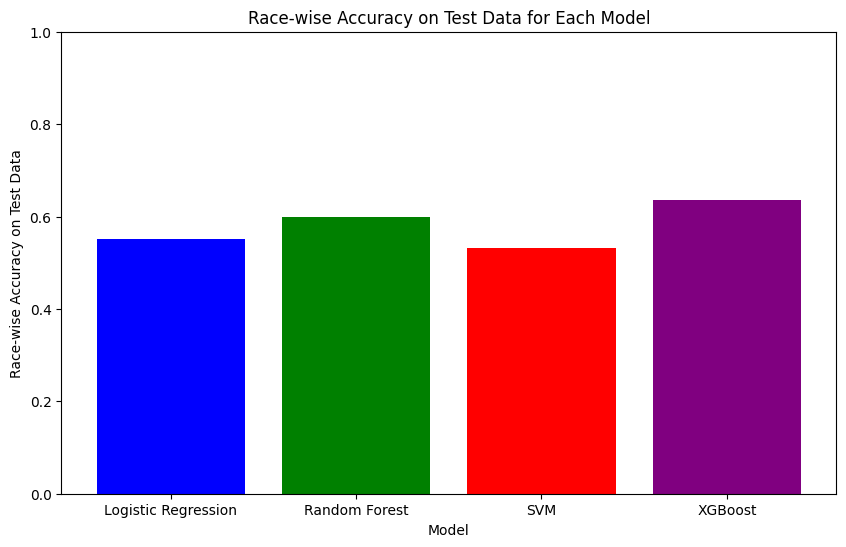

In [60]:
import matplotlib.pyplot as plt

# Extract race-wise accuracy on test data for each model
model_names = list(results.keys())
race_wise_accuracies = [results[model]['race_wise_accuracy_test'] for model in model_names]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, race_wise_accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Race-wise Accuracy on Test Data')
plt.title('Race-wise Accuracy on Test Data for Each Model')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.show()

In [ ]:
# Save the entire dataset into a CSV file named 'feature_selection.csv'
data.to_csv('data/new_features_winner.csv', index=False)

In [71]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Assuming the data and all helper functions are already defined as in your original code snippet.

# Define the models and parameter grids
model_param_grids = {
    'SVM': {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'feature_selection__k': [10, 20, 30]
    },
    'XGBoost': {
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 6],
        'classifier__n_estimators': [50, 100],
        'feature_selection__k': [10, 20, 30]
    }
}

# Preprocessor (unchanged)
preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaled', StandardScaler(), numerical_features_to_scale),
        ('num_unscaled', 'passthrough', numerical_features_unscaled),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Models dictionary (with parameters as defined before)
models = {
    'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Adjust scale_pos_weight for XGBoost based on class imbalance
ratio = (len(y_train) - sum(y_train)) / sum(y_train)
models['XGBoost'].set_params(scale_pos_weight=ratio)

# We will use a standard scorer like 'roc_auc' for hyperparameter tuning to save time
scoring_metric = 'roc_auc'
n_splits = 3  # fewer splits for quicker tuning
tscv = TimeSeriesSplit(n_splits=n_splits)

results = {}

for model_name, model in models.items():
    print(f"Processing {model_name} with hyperparameter tuning and feature selection...")
    
    # Build pipeline: preprocessor -> SelectKBest -> classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_classif)),
        ('classifier', model)
    ])
    
    # Parameter grid for current model
    param_grid = model_param_grids[model_name]
    
    # Perform GridSearchCV (or RandomizedSearchCV if preferred)
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scoring_metric,
        n_jobs=-1,
        cv=tscv,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Retrieve best pipeline
    best_pipeline = grid_search.best_estimator_
    print(f"Best params for {model_name}:", grid_search.best_params_)
    
    # Evaluate on test set using race-wise accuracy
    y_probs_test = best_pipeline.predict_proba(X_test)[:, 1]
    test_race_wise_accuracy = calculate_race_wise_accuracy(
        y_true=y_test.reset_index(drop=True),
        y_probs=y_probs_test,
        race_ids=race_ids_test.reset_index(drop=True),
        driver_names=driver_names_test.reset_index(drop=True)
    )
    
    # Optionally, do cross-validation with the best pipeline to get train performance
    # If desired, you can reuse cross_validate_race_wise or a simple metric to assess train performance.
    train_race_wise_acc = cross_validate_race_wise(best_pipeline.named_steps['classifier'], X_train, y_train, train_df, n_splits=3)
    
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'mean_race_wise_accuracy_train': train_race_wise_acc,
        'race_wise_accuracy_test': test_race_wise_accuracy
    }

# Print summary of results
print("\nSummary of Results with Feature Selection and Hyperparameter Tuning:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f" - Best Params: {metrics['best_params']}")
    print(f" - Mean Race-wise Accuracy on training data: {metrics['mean_race_wise_accuracy_train']:.4f}")
    print(f" - Race-wise Accuracy on test data: {metrics['race_wise_accuracy_test']:.4f}\n")


Processing SVM with hyperparameter tuning and feature selection...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best params for SVM: {'classifier__C': 0.1, 'classifier__kernel': 'linear', 'feature_selection__k': 20}
Processing XGBoost with hyperparameter tuning and feature selection...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params for XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 50, 'feature_selection__k': 10}

Summary of Results with Feature Selection and Hyperparameter Tuning:
SVM:
 - Best Params: {'classifier__C': 0.1, 'classifier__kernel': 'linear', 'feature_selection__k': 20}
 - Mean Race-wise Accuracy on training data: 0.8023
 - Race-wise Accuracy on test data: 0.5701

XGBoost:
 - Best Params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 50, 'feature_selection__k': 10}
 - Mean Race-wise Accuracy on training data: 0.8110
 - Race-wise Accur

In [73]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Assuming the data and all helper functions are already defined as in your original code snippet.

# Define the models and parameter grids
model_param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga'],
        'feature_selection__k': [10, 15, 20, 30]
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 5, 10, 15],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'feature_selection__k': [10, 15, 20, 30]
    }
}

# Preprocessor (unchanged)
preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaled', StandardScaler(), numerical_features_to_scale),
        ('num_unscaled', 'passthrough', numerical_features_unscaled),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Models dictionary (with parameters as defined before)
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42)
}

# We will use a standard scorer like 'roc_auc' for hyperparameter tuning to save time
scoring_metric = 'roc_auc'
n_splits = 3  # fewer splits for quicker tuning
tscv = TimeSeriesSplit(n_splits=n_splits)

results = {}

for model_name, model in models.items():
    print(f"Processing {model_name} with hyperparameter tuning and feature selection...")
    
    # Build pipeline: preprocessor -> SelectKBest -> classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_classif)),
        ('classifier', model)
    ])
    
    # Parameter grid for current model
    param_grid = model_param_grids[model_name]
    
    # Perform GridSearchCV (or RandomizedSearchCV if preferred)
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scoring_metric,
        n_jobs=-1,
        cv=tscv,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Retrieve best pipeline
    best_pipeline = grid_search.best_estimator_
    print(f"Best params for {model_name}:", grid_search.best_params_)
    
    # Evaluate on test set using race-wise accuracy
    y_probs_test = best_pipeline.predict_proba(X_test)[:, 1]
    test_race_wise_accuracy = calculate_race_wise_accuracy(
        y_true=y_test.reset_index(drop=True),
        y_probs=y_probs_test,
        race_ids=race_ids_test.reset_index(drop=True),
        driver_names=driver_names_test.reset_index(drop=True)
    )
    
    # Optionally, do cross-validation with the best pipeline to get train performance
    # If desired, you can reuse cross_validate_race_wise or a simple metric to assess train performance.
    train_race_wise_acc = cross_validate_race_wise(best_pipeline.named_steps['classifier'], X_train, y_train, train_df, n_splits=3)
    
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'mean_race_wise_accuracy_train': train_race_wise_acc,
        'race_wise_accuracy_test': test_race_wise_accuracy
    }

# Print summary of results
print("\nSummary of Results with Feature Selection and Hyperparameter Tuning:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f" - Best Params: {metrics['best_params']}")
    print(f" - Mean Race-wise Accuracy on training data: {metrics['mean_race_wise_accuracy_train']:.4f}")
    print(f" - Race-wise Accuracy on test data: {metrics['race_wise_accuracy_test']:.4f}\n")


Processing Logistic Regression with hyperparameter tuning and feature selection...
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best params for Logistic Regression: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'feature_selection__k': 20}
Processing Random Forest with hyperparameter tuning and feature selection...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best params for Random Forest: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300, 'feature_selection__k': 20}

Summary of Results with Feature Selection and Hyperparameter Tuning:
Logistic Regression:
 - Best Params: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'feature_selection__k': 20}
 - Mean Race-wise Accuracy on training data: 0.8271
 - Race-wise Accuracy on test data: 0.5794

Random Forest:
 - Best Params: {'classifier__max_

### Betting analysis - 2024 season

In [57]:
# Filter the test data for the 2023 season
test_df_2023 = test_df[test_df['year'] == 2024]

# Get the predicted probabilities for the 2023 season
y_probs_test_2023 = y_probs_test[test_df['year'] == 2024]

# Create a DataFrame with the necessary information
results_df_2023 = pd.DataFrame({
    'raceId': test_df_2023['raceId'],
    'circuitRef': test_df_2023['circuitRef'],
    'country': test_df_2023['country'],
    'driver_name': test_df_2023['driver_name'],
    'actual_winner': test_df_2023['winner'],
    'predicted_prob': y_probs_test_2023
})

# Get unique races for the 2023 season
unique_races_2023 = results_df_2023['raceId'].unique()

# Initialize lists to store the results
predicted_winners = []
actual_winners = []

# Iterate over each race
for race_id in unique_races_2023:
    race_data = results_df_2023[results_df_2023['raceId'] == race_id]
    
    # Predict the winner as the driver with the highest predicted probability
    predicted_winner = race_data.loc[race_data['predicted_prob'].idxmax()]
    actual_winner = race_data[race_data['actual_winner'] == 1]
    
    if not actual_winner.empty:
        actual_winner_name = actual_winner['driver_name'].values[0]
    else:
        actual_winner_name = None
    
    predicted_winners.append(predicted_winner['driver_name'])
    actual_winners.append(actual_winner_name)

# Create the final DataFrame
final_results_df_2023 = pd.DataFrame({
    'raceId': unique_races_2023,
    'circuitRef': [results_df_2023[results_df_2023['raceId'] == race_id]['circuitRef'].values[0] for race_id in unique_races_2023],
    'country': [results_df_2023[results_df_2023['raceId'] == race_id]['country'].values[0] for race_id in unique_races_2023],
    'predicted_winner': predicted_winners,
    'actual_winner': actual_winners
})

# Sort the final results DataFrame by raceId
final_results_df_2023_sorted = final_results_df_2023.sort_values(by='raceId')

# Display or further use the sorted DataFrame
print(final_results_df_2023_sorted)


    raceId     circuitRef        country predicted_winner    actual_winner
0     1121        bahrain        Bahrain  Charles Leclerc   Max Verstappen
1     1122         jeddah   Saudi Arabia   Max Verstappen   Max Verstappen
2     1123    albert_park      Australia     Carlos Sainz     Carlos Sainz
3     1124         suzuka          Japan   Max Verstappen   Max Verstappen
4     1125       shanghai          China   Max Verstappen   Max Verstappen
5     1126          miami            USA   Max Verstappen     Lando Norris
6     1127          imola          Italy   Max Verstappen   Max Verstappen
7     1128         monaco         Monaco  Charles Leclerc  Charles Leclerc
8     1129     villeneuve         Canada   George Russell   Max Verstappen
9     1130      catalunya          Spain   Max Verstappen   Max Verstappen
10    1131  red_bull_ring        Austria     Lando Norris   George Russell
11    1132    silverstone             UK   Lewis Hamilton   Lewis Hamilton
12    1133    hungaroring

In [58]:
import pandas as pd

# Assuming `race_ids_test`, `y_test`, and `y_probs_test` are already defined and contain the necessary data

# Function to calculate race-wise accuracy for a given year
def calculate_race_accuracy_for_year(year, race_ids, y_true, y_probs):
    # Filter data for the given year
    year_mask = (test_df['year'] == year)
    race_ids_year = race_ids[year_mask]
    y_true_year = y_true[year_mask]
    y_probs_year = y_probs[year_mask]
    
    # Calculate race-wise accuracy
    race_accuracy = calculate_race_wise_accuracy(
        y_true=y_true_year.reset_index(drop=True),
        y_probs=y_probs_year,
        race_ids=race_ids_year.reset_index(drop=True),
        driver_names=test_df[year_mask]['driver_name'].reset_index(drop=True)
    )
    return race_accuracy

# List of years to evaluate
years = [2020, 2021, 2022, 2023, 2024]

# Calculate race accuracy for each year
race_accuracies = [calculate_race_accuracy_for_year(year, race_ids_test, y_test, y_probs_test) for year in years]

# Create a DataFrame
race_accuracy_df = pd.DataFrame({
    'year': years,
    'race_accuracy': race_accuracies
})

# Calculate the average race accuracy
average_accuracy = race_accuracy_df['race_accuracy'].mean()

# Append the average to the DataFrame
average_row = pd.DataFrame({'year': ['Average'], 'race_accuracy': [average_accuracy]})
race_accuracy_df = pd.concat([race_accuracy_df, average_row], ignore_index=True)

# Display the DataFrame
print(race_accuracy_df)

      year  race_accuracy
0     2020       0.705882
1     2021       0.227273
2     2022       0.363636
3     2023       0.590909
4     2024       0.458333
5  Average       0.469207


In [59]:
import pandas as pd

# Function to convert American odds to decimal odds
def american_to_decimal(odds):
    if odds > 0:
        return round((odds / 100) + 1, 2)
    else:
        return round((100 / abs(odds)) + 1, 2)

# Load the CSV file
file_path = 'odds_fi_2024 - Full 1.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Clean and convert the 'odds predicted' column to numeric
data['odds predicted'] = pd.to_numeric(data['odds predicted'], errors='coerce')

# Create a new column for decimal odds
data['decimal_odds'] = data['odds predicted'].apply(lambda x: american_to_decimal(x) if not pd.isnull(x) else None)

# Calculate winnings for a €100 bet
data['race_winnings'] = data.apply(
    lambda row: round(100 * (row['decimal_odds'] - 1), 2) if row['predicted_winner'] == row['actual_winner'] else -100,
    axis=1
)

# Calculate cumulative winnings
data['total_winnings'] = data['race_winnings'].cumsum()

# Reorder the columns to place 'decimal_odds' next to 'odds predicted'
columns_order = [
    'circuit', 'country', 'odds favourite', 'predicted_winner',
    'actual_winner', 'odds predicted', 'decimal_odds', 'race_winnings', 'total_winnings'
]
data = data[columns_order]

# Save the updated DataFrame to a new CSV file
output_file_path = 'betting_analysis.csv'  # Replace with your desired output file path
data.to_csv(output_file_path, index=False)

# Optional: Display the first few rows of the updated DataFrame
print(data.head())


       circuit       country  odds favourite predicted_winner   actual_winner  \
0      bahrain       Bahrain  Max Verstappen   Max Verstappen  Max Verstappen   
1       jeddah  Saudi Arabia  Max Verstappen   Max Verstappen  Max Verstappen   
2  albert_park     Australia  Max Verstappen   Max Verstappen    Carlos Sainz   
3       suzuka         Japan  Max Verstappen   Max Verstappen  Max Verstappen   
4     shanghai         China  Max Verstappen   Max Verstappen  Max Verstappen   

   odds predicted  decimal_odds  race_winnings  total_winnings  
0            -600          1.17           17.0            17.0  
1            -800          1.12           12.0            29.0  
2            -700          1.14         -100.0           -71.0  
3            -700          1.14           14.0           -57.0  
4           -1200          1.08            8.0           -49.0  


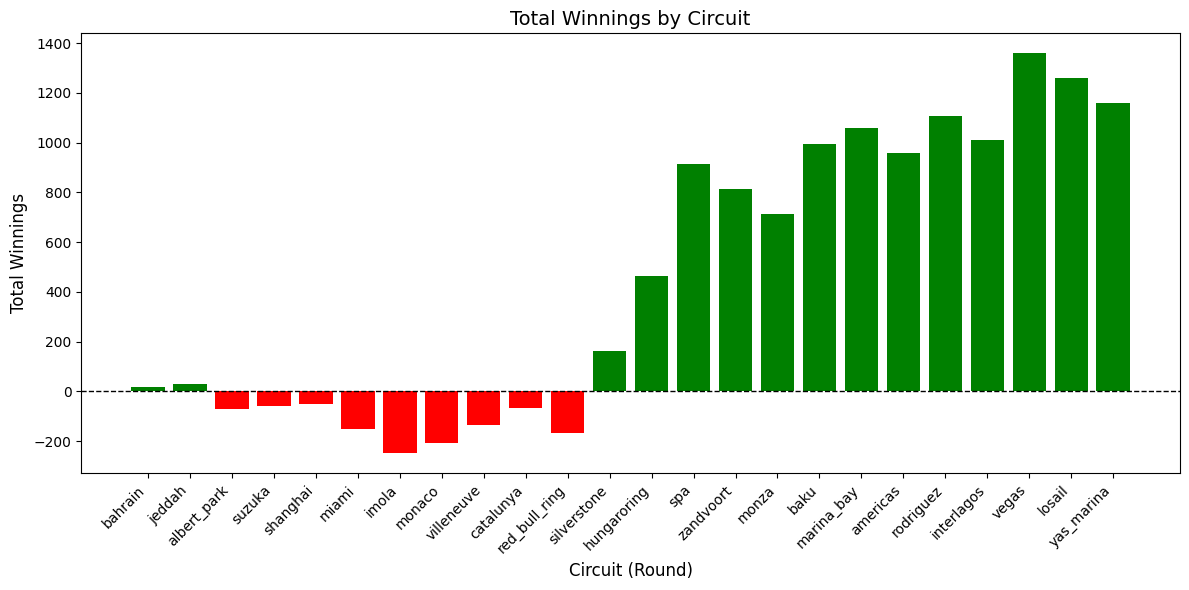

In [61]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot configuration
colors = ['green' if winnings > 0 else 'red' for winnings in data['total_winnings']]

plt.figure(figsize=(12, 6))
plt.bar(data['circuit'], data['total_winnings'], color=colors)
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.xlabel('Circuit (Round)', fontsize=12)
plt.ylabel('Total Winnings', fontsize=12)
plt.title('Total Winnings by Circuit', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()


### Predicting position - (podium. points, no-points)

Regression: predict the final positon and sort values from low to high. Then assaign each driver their positon and compare to actual group position.

In [5]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(actual, predicted):
    """
    Plots the confusion matrix for the given actual and predicted values.

    Parameters:
    actual (array-like): The actual labels.
    predicted (array-like): The predicted labels.
    """
    # Calculate the confusion matrix
    cm = confusion_matrix(actual, predicted)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [69]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Load the dataset
data = pd.read_csv('data/cleaned_data_EDA.csv')
data['date'] = pd.to_datetime(data['date'])

# Create the finishing_group target
data['finishing_group'] = data['position'].apply(
    lambda x: 0 if x <= 3 else (1 if x <= 10 else 2)
)

# Implement the new features (ensure these functions are defined)
data = calculate_constructor_reliability(data)
data = calculate_driver_reliability(data)
data = add_driver_home_race(data)
data = add_constructor_home_race(data)
data = avg_performance_3(data)

# Features and target
features = [
    'grid', 'age_at_gp_in_days', 'q1_seconds', 'prev_points', 'prev_champ_position',
    'circuitRef', 'round', 'prev_wins', 'driver_country', 'constructor_name',
    'country', 'constructor_country', 'driver_name', 'year',
    'constructor_reliability', 'driver_reliability',
    'driver_home_race', 'constructor_home_race', 'avg_performance_3'
]

# For regression, we'll predict the actual finishing position (continuous)
target_position = 'position'
actual_group = 'finishing_group'

# Subset the data
df = data[features + ['raceId', target_position, actual_group]].copy()
df = df.dropna(subset=features + [target_position, actual_group])

# Split data into training and test sets based on year
train_df = df[df['year'] < 2020].reset_index(drop=True)
test_df = df[df['year'] >= 2020].reset_index(drop=True)

X_train = train_df[features]
y_train = train_df[target_position]

X_test = test_df[features]
y_test = test_df[target_position]

race_ids_test = test_df['raceId']

# Define categorical and numerical features
numerical_features_to_scale = ['age_at_gp_in_days', 'q1_seconds', 'year', 'avg_performance_3']
numerical_features_unscaled = [
    'grid', 'prev_points', 'prev_champ_position', 'prev_wins',
    'driver_home_race', 'round', 'constructor_home_race',
    'constructor_reliability', 'driver_reliability'
]
categorical_features = [
    'driver_country', 'constructor_name', 'country',
    'constructor_country', 'driver_name', 'circuitRef'
]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaled', StandardScaler(), numerical_features_to_scale),
        ('num_unscaled', 'passthrough', numerical_features_unscaled),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# ====================================
# Function to Assign Groups After Regression
# ====================================
def assign_groups_after_regression(race_df, predictions_col='predicted_position'):
    # Sort by predicted position
    race_df = race_df.sort_values(by=predictions_col, ascending=True).reset_index(drop=True)
    # Assign groups
    race_df['predicted_group'] = 2  # default to no-points
    if len(race_df) >= 3:
        race_df.loc[:2, 'predicted_group'] = 0  # top 3 = podium
    if len(race_df) > 3:
        end_points = min(10, len(race_df))  # ensure we don't exceed the number of drivers
        race_df.loc[3:end_points-1, 'predicted_group'] = 1  # next 7 = points
    return race_df

# ====================================
# Functions for Evaluation
# ====================================
def evaluate_regression_groups(y_true_group, y_pred_group):
    cm = confusion_matrix(y_true_group, y_pred_group, labels=[0,1,2])
    f1 = f1_score(y_true_group, y_pred_group, average='weighted')
    return cm, f1

def calculate_group_race_wise_accuracy(df, actual_col='finishing_group', predicted_col='predicted_group'):
    accuracies = []
    for race_id in df['raceId'].unique():
        race_data = df[df['raceId'] == race_id]
        race_accuracy = accuracy_score(race_data[actual_col], race_data[predicted_col])
        accuracies.append(race_accuracy)
    return np.mean(accuracies)

# ====================================
# Cross-Validation Function for Regression
# ====================================
def cross_validate_regression(X, y, df, preprocessor, model, n_splits=5, random_state=42):
    unique_races = df['raceId'].unique()
    gkf = GroupKFold(n_splits=n_splits)
    race_ids = df['raceId']

    fold_metrics_f1 = []
    fold_metrics_acc = []

    for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=race_ids), 1):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        df_val_fold = df.iloc[val_idx].reset_index(drop=True)

        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])

        pipeline.fit(X_train_fold, y_train_fold)
        y_pred_val = pipeline.predict(X_val_fold)

        # Assign groups on validation set
        results_val = df_val_fold.copy()
        results_val['predicted_position'] = y_pred_val

        all_race_results = []
        for rid in results_val['raceId'].unique():
            race_data = results_val[results_val['raceId'] == rid].copy()
            race_data = assign_groups_after_regression(race_data, 'predicted_position')
            all_race_results.append(race_data)

        all_race_results_df = pd.concat(all_race_results, ignore_index=True)

        # Evaluate metrics
        cm, f1 = evaluate_regression_groups(all_race_results_df[actual_group], all_race_results_df['predicted_group'])
        acc = calculate_group_race_wise_accuracy(all_race_results_df, actual_col=actual_group, predicted_col='predicted_group')

        fold_metrics_f1.append(f1)
        fold_metrics_acc.append(acc)

        print(f"Fold {fold}: F1 score = {f1:.4f}, Group Race-wise Accuracy = {acc:.4f}")

    mean_f1 = np.mean(fold_metrics_f1) if len(fold_metrics_f1) > 0 else 0
    mean_acc = np.mean(fold_metrics_acc) if len(fold_metrics_acc) > 0 else 0
    return mean_f1, mean_acc

In [7]:

# ====================================
# RandomForestRegressor
# ====================================
print("Cross-validating with RandomForestRegressor...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
mean_f1_rf, mean_acc_rf = cross_validate_regression(X_train, y_train, train_df, preprocessor, rf_model, n_splits=5)
print(f"\nRandomForest - Mean F1 Score (CV): {mean_f1_rf:.4f}, Mean Group Race-wise Accuracy (CV): {mean_acc_rf:.4f}")

# Train on full training set and evaluate on test set
final_pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf_model)
])
final_pipeline_rf.fit(X_train, y_train)
y_pred_test_rf = final_pipeline_rf.predict(X_test)

results_test = test_df.copy()
results_test['predicted_position'] = y_pred_test_rf

all_test_race_results = []
for rid in results_test['raceId'].unique():
    race_data = results_test[results_test['raceId'] == rid].copy()
    race_data = assign_groups_after_regression(race_data, 'predicted_position')
    all_test_race_results.append(race_data)

all_test_race_results_df = pd.concat(all_test_race_results, ignore_index=True)

cm_test_rf, f1_test_rf = evaluate_regression_groups(all_test_race_results_df[actual_group], all_test_race_results_df['predicted_group'])
acc_test_rf = calculate_group_race_wise_accuracy(all_test_race_results_df, actual_col=actual_group, predicted_col='predicted_group')

print("\nRandomForest - Test Set Evaluation:")
print("Confusion Matrix:")
print(cm_test_rf)
print(f"F1 Score (weighted): {f1_test_rf:.4f}")
print(f"Group Race-wise Accuracy: {acc_test_rf:.4f}")

Cross-validating with RandomForestRegressor...
Fold 1: F1 score = 0.6900, Group Race-wise Accuracy = 0.6900
Fold 2: F1 score = 0.7077, Group Race-wise Accuracy = 0.7074
Fold 3: F1 score = 0.7198, Group Race-wise Accuracy = 0.7210
Fold 4: F1 score = 0.7086, Group Race-wise Accuracy = 0.7084
Fold 5: F1 score = 0.7030, Group Race-wise Accuracy = 0.7030

RandomForest - Mean F1 Score (CV): 0.7058, Mean Group Race-wise Accuracy (CV): 0.7060

RandomForest - Test Set Evaluation:
Confusion Matrix:
[[213  99   8]
 [102 462 174]
 [  6 188 790]]
F1 Score (weighted): 0.7180
Group Race-wise Accuracy: 0.7176


In [8]:
# ====================================
# Linear Regression
# ====================================
from sklearn.linear_model import LinearRegression

# Initialize Linear Regression model
lr_model = LinearRegression()

# Perform cross-validation for Linear Regression
print("Cross-validating with LinearRegression...")
mean_f1_lr, mean_acc_lr = cross_validate_regression(X_train, y_train, train_df, preprocessor, lr_model, n_splits=5)
print(f"\nLinearRegression - Mean F1 Score (CV): {mean_f1_lr:.4f}, Mean Group Race-wise Accuracy (CV): {mean_acc_lr:.4f}")

# Train Linear Regression on the full training set
final_pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lr_model)
])
final_pipeline_lr.fit(X_train, y_train)

# Predict finishing positions on the test set
y_pred_test_lr = final_pipeline_lr.predict(X_test)

# Create a DataFrame for test results
results_test_lr = test_df.copy()
results_test_lr['predicted_position'] = y_pred_test_lr

# Assign groups race by race
all_test_race_results_lr = []
for rid in results_test_lr['raceId'].unique():
    race_data = results_test_lr[results_test_lr['raceId'] == rid].copy()
    race_data = assign_groups_after_regression(race_data, 'predicted_position')
    all_test_race_results_lr.append(race_data)

# Combine all race results into a single DataFrame
all_test_race_results_lr_df = pd.concat(all_test_race_results_lr, ignore_index=True)

# Evaluate Linear Regression performance on the test set
cm_test_lr, f1_test_lr = evaluate_regression_groups(
    all_test_race_results_lr_df[actual_group],  # Actual groups
    all_test_race_results_lr_df['predicted_group']  # Predicted groups
)
acc_test_lr = calculate_group_race_wise_accuracy(
    all_test_race_results_lr_df,
    actual_col=actual_group,
    predicted_col='predicted_group'
)

# Display results
print("\nLinearRegression - Test Set Evaluation:")
print("Confusion Matrix:")
#
print(f"F1 Score (weighted): {f1_test_lr:.4f}")
print(f"Group Race-wise Accuracy: {acc_test_lr:.4f}")


Cross-validating with LinearRegression...
Fold 1: F1 score = 0.6817, Group Race-wise Accuracy = 0.6804
Fold 2: F1 score = 0.7222, Group Race-wise Accuracy = 0.7217
Fold 3: F1 score = 0.7129, Group Race-wise Accuracy = 0.7133
Fold 4: F1 score = 0.7230, Group Race-wise Accuracy = 0.7226
Fold 5: F1 score = 0.7061, Group Race-wise Accuracy = 0.7087

LinearRegression - Mean F1 Score (CV): 0.7092, Mean Group Race-wise Accuracy (CV): 0.7094

LinearRegression - Test Set Evaluation:
Confusion Matrix:
F1 Score (weighted): 0.7273
Group Race-wise Accuracy: 0.7262


In [9]:
from sklearn.svm import SVR

# ====================================
# SVM Regressor
# ====================================
print("Cross-validating with SVM Regressor...")
svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Perform cross-validation for SVM Regressor
mean_f1_svm, mean_acc_svm = cross_validate_regression(X_train, y_train, train_df, preprocessor, svm_model, n_splits=5)
print(f"\nSVM Regressor - Mean F1 Score (CV): {mean_f1_svm:.4f}, Mean Group Race-wise Accuracy (CV): {mean_acc_svm:.4f}")

# Train SVM Regressor on the full training set
final_pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', svm_model)
])
final_pipeline_svm.fit(X_train, y_train)

# Predict finishing positions on the test set
y_pred_test_svm = final_pipeline_svm.predict(X_test)

# Create a DataFrame for test results
results_test_svm = test_df.copy()
results_test_svm['predicted_position'] = y_pred_test_svm

# Assign groups race by race
all_test_race_results_svm = []
for rid in results_test_svm['raceId'].unique():
    race_data = results_test_svm[results_test_svm['raceId'] == rid].copy()
    race_data = assign_groups_after_regression(race_data, 'predicted_position')
    all_test_race_results_svm.append(race_data)

# Combine all race results into a single DataFrame
all_test_race_results_svm_df = pd.concat(all_test_race_results_svm, ignore_index=True)

# Evaluate SVM Regressor performance on the test set
cm_test_svm, f1_test_svm = evaluate_regression_groups(
    all_test_race_results_svm_df[actual_group],  # Actual groups
    all_test_race_results_svm_df['predicted_group']  # Predicted groups
)
acc_test_svm = calculate_group_race_wise_accuracy(
    all_test_race_results_svm_df,
    actual_col=actual_group,
    predicted_col='predicted_group'
)

# Display results
print("\nSVM Regressor - Test Set Evaluation:")
print("Confusion Matrix:")
print(cm_test_svm)
print(f"F1 Score (weighted): {f1_test_svm:.4f}")
print(f"Group Race-wise Accuracy: {acc_test_svm:.4f}")


Cross-validating with SVM Regressor...
Fold 1: F1 score = 0.6564, Group Race-wise Accuracy = 0.6601
Fold 2: F1 score = 0.6827, Group Race-wise Accuracy = 0.6785
Fold 3: F1 score = 0.6935, Group Race-wise Accuracy = 0.6940
Fold 4: F1 score = 0.6811, Group Race-wise Accuracy = 0.6823
Fold 5: F1 score = 0.6704, Group Race-wise Accuracy = 0.6719

SVM Regressor - Mean F1 Score (CV): 0.6768, Mean Group Race-wise Accuracy (CV): 0.6774

SVM Regressor - Test Set Evaluation:
Confusion Matrix:
[[215  97   8]
 [ 67 463 208]
 [ 39 189 756]]
F1 Score (weighted): 0.7027
Group Race-wise Accuracy: 0.7017


In [10]:
from xgboost import XGBRegressor

# ====================================
# XGBoost Regressor
# ====================================
print("Cross-validating with XGBoost Regressor...")
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

# Perform cross-validation for XGBoost Regressor
mean_f1_xgb, mean_acc_xgb = cross_validate_regression(X_train, y_train, train_df, preprocessor, xgb_model, n_splits=5)
print(f"\nXGBoost Regressor - Mean F1 Score (CV): {mean_f1_xgb:.4f}, Mean Group Race-wise Accuracy (CV): {mean_acc_xgb:.4f}")

# Train XGBoost Regressor on the full training set
final_pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])
final_pipeline_xgb.fit(X_train, y_train)

# Predict finishing positions on the test set
y_pred_test_xgb = final_pipeline_xgb.predict(X_test)

# Create a DataFrame for test results
results_test_xgb = test_df.copy()
results_test_xgb['predicted_position'] = y_pred_test_xgb

# Assign groups race by race
all_test_race_results_xgb = []
for rid in results_test_xgb['raceId'].unique():
    race_data = results_test_xgb[results_test_xgb['raceId'] == rid].copy()
    race_data = assign_groups_after_regression(race_data, 'predicted_position')
    all_test_race_results_xgb.append(race_data)

# Combine all race results into a single DataFrame
all_test_race_results_xgb_df = pd.concat(all_test_race_results_xgb, ignore_index=True)

# Evaluate XGBoost Regressor performance on the test set
cm_test_xgb, f1_test_xgb = evaluate_regression_groups(
    all_test_race_results_xgb_df[actual_group],  # Actual groups
    all_test_race_results_xgb_df['predicted_group']  # Predicted groups
)
acc_test_xgb = calculate_group_race_wise_accuracy(
    all_test_race_results_xgb_df,
    actual_col=actual_group,
    predicted_col='predicted_group'
)

# Display results
print("\nXGBoost Regressor - Test Set Evaluation:")
print("Confusion Matrix:")
print(cm_test_xgb)
print(f"F1 Score (weighted): {f1_test_xgb:.4f}")
print(f"Group Race-wise Accuracy: {acc_test_xgb:.4f}")


# plot confusion matrix


Cross-validating with XGBoost Regressor...
Fold 1: F1 score = 0.7094, Group Race-wise Accuracy = 0.7090
Fold 2: F1 score = 0.7153, Group Race-wise Accuracy = 0.7143
Fold 3: F1 score = 0.7192, Group Race-wise Accuracy = 0.7200
Fold 4: F1 score = 0.7155, Group Race-wise Accuracy = 0.7172
Fold 5: F1 score = 0.7118, Group Race-wise Accuracy = 0.7119

XGBoost Regressor - Mean F1 Score (CV): 0.7142, Mean Group Race-wise Accuracy (CV): 0.7145

XGBoost Regressor - Test Set Evaluation:
Confusion Matrix:
[[226  87   7]
 [ 91 477 170]
 [  4 185 795]]
F1 Score (weighted): 0.7341
Group Race-wise Accuracy: 0.7328


In [70]:
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd


def assign_groups_after_regression(race_df, predictions_col='predicted_position'):
    race_df = race_df.sort_values(by=predictions_col, ascending=True).reset_index(drop=True)
    race_df['predicted_group'] = 2
    if len(race_df) >= 3:
        race_df.loc[:2, 'predicted_group'] = 0
    if len(race_df) > 3:
        end_points = min(10, len(race_df))
        race_df.loc[3:end_points-1, 'predicted_group'] = 1
    return race_df

def evaluate_regression_groups(y_true_group, y_pred_group):
    cm = confusion_matrix(y_true_group, y_pred_group, labels=[0,1,2])
    f1 = f1_score(y_true_group, y_pred_group, average='weighted')
    return cm, f1

def calculate_group_race_wise_accuracy(df, actual_col='finishing_group', predicted_col='predicted_group'):
    accuracies = []
    for race_id in df['raceId'].unique():
        race_data = df[df['raceId'] == race_id]
        race_accuracy = accuracy_score(race_data[actual_col], race_data[predicted_col])
        accuracies.append(race_accuracy)
    return np.mean(accuracies)

def cross_validate_regression(X, y, df, pipeline, n_splits=5):
    unique_races = df['raceId'].unique()
    gkf = GroupKFold(n_splits=n_splits)
    race_ids = df['raceId']

    fold_metrics_f1 = []
    fold_metrics_acc = []

    for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=race_ids), 1):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        df_val_fold = df.iloc[val_idx].reset_index(drop=True)

        pipeline.fit(X_train_fold, y_train_fold)
        y_pred_val = pipeline.predict(X_val_fold)

        results_val = df_val_fold.copy()
        results_val['predicted_position'] = y_pred_val

        all_race_results = []
        for rid in results_val['raceId'].unique():
            race_data = results_val[results_val['raceId'] == rid].copy()
            race_data = assign_groups_after_regression(race_data, 'predicted_position')
            all_race_results.append(race_data)

        all_race_results_df = pd.concat(all_race_results, ignore_index=True)
        cm, f1 = evaluate_regression_groups(all_race_results_df[actual_group], all_race_results_df['predicted_group'])
        acc = calculate_group_race_wise_accuracy(all_race_results_df, actual_col=actual_group, predicted_col='predicted_group')

        fold_metrics_f1.append(f1)
        fold_metrics_acc.append(acc)
        print(f"Fold {fold}: F1 = {f1:.4f}, Acc = {acc:.4f}")

    mean_f1 = np.mean(fold_metrics_f1)
    mean_acc = np.mean(fold_metrics_acc)
    return mean_f1, mean_acc

# Parameter grids
rf_param_grid = {
    'select_features__k': [10, 20, 30],
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 5, 10]
}

lr_param_grid = {
    'select_features__k': [10, 20, 25, 20]
}

svr_param_grid = {
    'select_features__k': [10, 20, 30],
    'regressor__C': [0.1, 1],
    'regressor__epsilon': [0.1, 0.2]
}

xgb_param_grid = {
    'select_features__k': [10, 20, 30],
    'regressor__n_estimators': [50, 100, 200],
    'regressor__learning_rate': [0.05, 0.1, 0.2],
}

def tune_model(X, y, df, base_model, param_grid, n_iter=4):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('select_features', SelectKBest(score_func=f_regression)),
        ('regressor', base_model)
    ])

    gkf = GroupKFold(n_splits=3)
    race_ids = df['raceId']

    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring='neg_mean_squared_error',
        cv=gkf.split(X, y, groups=race_ids),
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    search.fit(X, y)
    return search.best_estimator_, search.best_params_

# ====================================
# RandomForest
# ====================================
print("\nTuning RandomForest...")
best_rf_pipeline, best_rf_params = tune_model(X_train, y_train, train_df, RandomForestRegressor(random_state=42), rf_param_grid)
print("Best RF Params:", best_rf_params)

mean_f1_rf, mean_acc_rf = cross_validate_regression(X_train, y_train, train_df, best_rf_pipeline, n_splits=5)
print(f"RF (Tuned) - Mean F1 (CV): {mean_f1_rf:.4f}, Mean Acc (CV): {mean_acc_rf:.4f}")

# Evaluate on test set
best_rf_pipeline.fit(X_train, y_train)
y_pred_test_rf = best_rf_pipeline.predict(X_test)
results_test_rf = test_df.copy()
results_test_rf['predicted_position'] = y_pred_test_rf
all_test_race_results_rf = []
for rid in results_test_rf['raceId'].unique():
    race_data = results_test_rf[results_test_rf['raceId'] == rid].copy()
    race_data = assign_groups_after_regression(race_data, 'predicted_position')
    all_test_race_results_rf.append(race_data)
all_test_race_results_rf_df = pd.concat(all_test_race_results_rf, ignore_index=True)
cm_test_rf, f1_test_rf = evaluate_regression_groups(all_test_race_results_rf_df[actual_group], all_test_race_results_rf_df['predicted_group'])
acc_test_rf = calculate_group_race_wise_accuracy(all_test_race_results_rf_df)
print("\nRF (Tuned) Test Results:")
print("Confusion Matrix:\n", cm_test_rf)
print(f"F1: {f1_test_rf:.4f}, Acc: {acc_test_rf:.4f}")

# ====================================
# LinearRegression
# ====================================
print("\nTuning LinearRegression...")
best_lr_pipeline, best_lr_params = tune_model(X_train, y_train, train_df, LinearRegression(), lr_param_grid)
print("Best LR Params:", best_lr_params)

mean_f1_lr, mean_acc_lr = cross_validate_regression(X_train, y_train, train_df, best_lr_pipeline, n_splits=5)
print(f"LR (Tuned) - Mean F1 (CV): {mean_f1_lr:.4f}, Mean Acc (CV): {mean_acc_lr:.4f}")

# Test set evaluation for LinearRegression
best_lr_pipeline.fit(X_train, y_train)
y_pred_test_lr = best_lr_pipeline.predict(X_test)
results_test_lr = test_df.copy()
results_test_lr['predicted_position'] = y_pred_test_lr
all_test_race_results_lr = []
for rid in results_test_lr['raceId'].unique():
    race_data = results_test_lr[results_test_lr['raceId'] == rid].copy()
    race_data = assign_groups_after_regression(race_data, 'predicted_position')
    all_test_race_results_lr.append(race_data)
all_test_race_results_lr_df = pd.concat(all_test_race_results_lr, ignore_index=True)
cm_test_lr, f1_test_lr = evaluate_regression_groups(all_test_race_results_lr_df[actual_group], all_test_race_results_lr_df['predicted_group'])
acc_test_lr = calculate_group_race_wise_accuracy(all_test_race_results_lr_df)
print("\nLR (Tuned) Test Results:")
print("Confusion Matrix:\n", cm_test_lr)
print(f"F1: {f1_test_lr:.4f}, Acc: {acc_test_lr:.4f}")

# ====================================
# SVR
# ====================================
print("\nTuning SVR...")
best_svr_pipeline, best_svr_params = tune_model(X_train, y_train, train_df, SVR(), svr_param_grid)
print("Best SVR Params:", best_svr_params)

mean_f1_svr, mean_acc_svr = cross_validate_regression(X_train, y_train, train_df, best_svr_pipeline, n_splits=5)
print(f"SVR (Tuned) - Mean F1 (CV): {mean_f1_svr:.4f}, Mean Acc (CV): {mean_acc_svr:.4f}")

# Test set evaluation for SVR
best_svr_pipeline.fit(X_train, y_train)
y_pred_test_svr = best_svr_pipeline.predict(X_test)
results_test_svr = test_df.copy()
results_test_svr['predicted_position'] = y_pred_test_svr
all_test_race_results_svr = []
for rid in results_test_svr['raceId'].unique():
    race_data = results_test_svr[results_test_svr['raceId'] == rid].copy()
    race_data = assign_groups_after_regression(race_data, 'predicted_position')
    all_test_race_results_svr.append(race_data)
all_test_race_results_svr_df = pd.concat(all_test_race_results_svr, ignore_index=True)
cm_test_svr, f1_test_svr = evaluate_regression_groups(all_test_race_results_svr_df[actual_group], all_test_race_results_svr_df['predicted_group'])
acc_test_svr = calculate_group_race_wise_accuracy(all_test_race_results_svr_df)
print("\nSVR (Tuned) Test Results:")
print("Confusion Matrix:\n", cm_test_svr)
print(f"F1: {f1_test_svr:.4f}, Acc: {acc_test_svr:.4f}")

# ====================================
# XGBRegressor
# ====================================
print("\nTuning XGBRegressor...")
best_xgb_pipeline, best_xgb_params = tune_model(X_train, y_train, train_df, XGBRegressor(random_state=42, verbosity=0), xgb_param_grid)
print("Best XGB Params:", best_xgb_params)

mean_f1_xgb, mean_acc_xgb = cross_validate_regression(X_train, y_train, train_df, best_xgb_pipeline, n_splits=5)
print(f"XGB (Tuned) - Mean F1 (CV): {mean_f1_xgb:.4f}, Mean Acc (CV): {mean_acc_xgb:.4f}")

# Test set evaluation for XGBRegressor
best_xgb_pipeline.fit(X_train, y_train)
y_pred_test_xgb = best_xgb_pipeline.predict(X_test)
results_test_xgb = test_df.copy()
results_test_xgb['predicted_position'] = y_pred_test_xgb
all_test_race_results_xgb = []
for rid in results_test_xgb['raceId'].unique():
    race_data = results_test_xgb[results_test_xgb['raceId'] == rid].copy()
    race_data = assign_groups_after_regression(race_data, 'predicted_position')
    all_test_race_results_xgb.append(race_data)
all_test_race_results_xgb_df = pd.concat(all_test_race_results_xgb, ignore_index=True)
cm_test_xgb, f1_test_xgb = evaluate_regression_groups(all_test_race_results_xgb_df[actual_group], all_test_race_results_xgb_df['predicted_group'])
acc_test_xgb = calculate_group_race_wise_accuracy(all_test_race_results_xgb_df)
print("\nXGB (Tuned) Test Results:")
print("Confusion Matrix:\n", cm_test_xgb)
print(f"F1: {f1_test_xgb:.4f}, Acc: {acc_test_xgb:.4f}")


Tuning RandomForest...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best RF Params: {'select_features__k': 20, 'regressor__n_estimators': 100, 'regressor__max_depth': 5}
Fold 1: F1 = 0.6829, Acc = 0.6810
Fold 2: F1 = 0.7253, Acc = 0.7258
Fold 3: F1 = 0.7349, Acc = 0.7349
Fold 4: F1 = 0.7344, Acc = 0.7346
Fold 5: F1 = 0.7181, Acc = 0.7187
RF (Tuned) - Mean F1 (CV): 0.7191, Mean Acc (CV): 0.7190

RF (Tuned) Test Results:
Confusion Matrix:
 [[221  94   5]
 [ 96 469 173]
 [  4 186 794]]
F1: 0.7273, Acc: 0.7261

Tuning LinearRegression...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best LR Params: {'select_features__k': 10}
Fold 1: F1 = 0.6929, Acc = 0.6904
Fold 2: F1 = 0.7247, Acc = 0.7247
Fold 3: F1 = 0.7223, Acc = 0.7234
Fold 4: F1 = 0.7249, Acc = 0.7243
Fold 5: F1 = 0.7175, Acc = 0.7176
LR (Tuned) - Mean F1 (CV): 0.7164, Mean Acc (CV): 0.7161

LR (Tuned) Test Results:
Confusion Matrix:
 [[210 105   5]
 [107 460 171]
 [  4 184 796]]
F1: 0.7185, Acc: 0.7175

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have arrays for each model's true labels and predicted probabilities:
# y_true_rf, y_prob_rf
# y_true_lr, y_prob_lr
# y_true_svr, y_prob_svr
# y_true_xgb, y_prob_xgb

# Dictionary of model names and their corresponding (y_true, y_prob) tuples
models = {
    'Random Forest': (y_true_rf, y_prob_rf),
    'Linear Regression': (y_true_lr, y_prob_lr),
    'SVR': (y_true_svr, y_prob_svr),
    'XGBRegressor': (y_true_xgb, y_prob_xgb)
}

plt.figure(figsize=(8,6))

for model_name, (y_true, y_prob) in models.items():
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    model_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {model_auc:.2f})')

# Plot a reference line for random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.show()


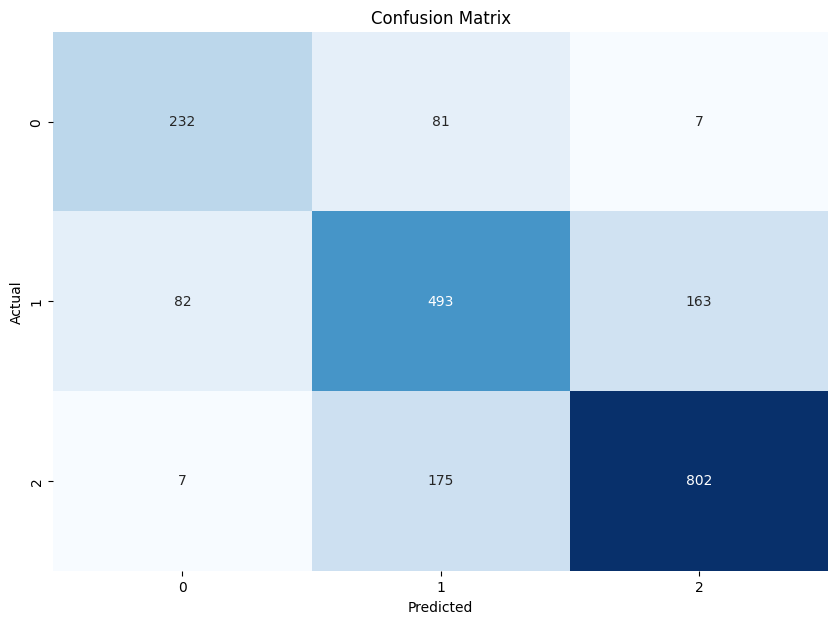

In [ ]:
#print confusion matrix for best performing model (xgb)
plot_confusion_matrix(all_test_race_results_xgb_df[actual_group], all_test_race_results_xgb_df['predicted_group'])


In [ ]:
#plot roc curve for each model and auc score

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Function to plot ROC curve
def plot_roc_curve(y_true, y_probs, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc_score = roc_auc_score(y_true, y_probs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'{model_name} (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.show()

### Multiclass approach

In [70]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score


# Load the dataset
data = pd.read_csv('data/cleaned_data_EDA.csv')
data['date'] = pd.to_datetime(data['date'])

# Create the three-class target
# 0 = podium (pos 1-3), 1 = points (pos 4-10), 2 = non-points (pos 11+)
data['finishing_group'] = data['position'].apply(
    lambda x: 0 if x <= 3 else (1 if x <= 10 else 2)
)

# Implement the new features (assuming these functions are defined)
data = calculate_constructor_reliability(data)
data = calculate_driver_reliability(data)
data = add_driver_home_race(data)
data = add_constructor_home_race(data)
data = avg_performance_3(data)

# Select features and target
features = [
    'grid', 'age_at_gp_in_days', 'q1_seconds', 'prev_points', 'prev_champ_position',
    'circuitRef', 'round', 'prev_wins', 'driver_country', 'constructor_name',
    'country', 'constructor_country', 'driver_name', 'year',
    # New features
    'constructor_reliability', 'driver_reliability',
    'driver_home_race', 'constructor_home_race', 'avg_performance_3'
]

target = 'finishing_group'

# Subset the data
df = data[features + ['raceId', target]].copy()
df = df.dropna(subset=features + [target])

# Define categorical and numerical features
numerical_features_to_scale = ['age_at_gp_in_days', 'q1_seconds', 'year', 'avg_performance_3']
numerical_features_unscaled = [
    'grid', 'prev_points', 'prev_champ_position', 'prev_wins',
    'driver_home_race', 'round', 'constructor_home_race',
    'constructor_reliability', 'driver_reliability'
]
categorical_features = [
    'driver_country', 'constructor_name', 'country',
    'constructor_country', 'driver_name', 'circuitRef'
]

# Split data into training and test sets based on year
train_df = df[df['year'] < 2020].reset_index(drop=True)
test_df = df[df['year'] >= 2020].reset_index(drop=True)

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

race_ids_test = test_df['raceId']
driver_names_test = test_df['driver_name']

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaled', StandardScaler(), numerical_features_to_scale),
        ('num_unscaled', 'passthrough', numerical_features_unscaled),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# ===============================
# Updated Group Accuracy Function
# ===============================
def calculate_group_accuracy(y_true, y_proba, race_ids, classes):
    """
    Calculate race-wise accuracy by enforcing group size constraints:
    - Exactly 3 drivers in the podium (class 0)
    - Exactly 7 drivers in points (class 1)
    - Remaining drivers in non-points (class 2)

    Parameters:
    - y_true: True finishing group labels
    - y_proba: Predicted probabilities for each class
    - race_ids: Race IDs for each sample
    - classes: Array of class labels (should be [0,1,2])

    Returns:
    - Mean race-wise accuracy
    """
    results_df = pd.DataFrame({
        'raceId': race_ids,
        'actual': y_true
    })

    # Add probability columns for each class
    for idx, cls in enumerate(classes):
        results_df[f'prob_class_{cls}'] = y_proba[:, idx]

    unique_races = results_df['raceId'].unique()
    accuracies = []

    for race_id in unique_races:
        race_data = results_df[results_df['raceId'] == race_id].copy()

        # Initialize all predictions to non-points (2)
        race_data['predicted'] = 2  # Non-points

        # Assign Podium (Group 0): top 3 by prob_class_0
        podium_candidates = race_data.sort_values(by='prob_class_0', ascending=False).head(3)
        race_data.loc[podium_candidates.index, 'predicted'] = 0

        # Assign Points (Group 1): top 7 from remaining by prob_class_1
        remaining = race_data[race_data['predicted'] == 2]
        points_candidates = remaining.sort_values(by='prob_class_1', ascending=False).head(7)
        race_data.loc[points_candidates.index, 'predicted'] = 1

        # Non-points remain as 2

        # Calculate accuracy for this race
        race_acc = accuracy_score(race_data['actual'], race_data['predicted'])
        accuracies.append(race_acc)

    return np.mean(accuracies) if len(accuracies) > 0 else 0

# ===================================
# Updated Cross-Validation Function
# ===================================
def cross_validate_group_accuracy(model, X, y, df, preprocessor, n_splits=5):
    """
    Perform group-aware cross-validation and calculate mean race-wise group accuracy.

    Parameters:
    - model: Classifier instance (unfitted).
    - X: Feature dataframe.
    - y: Target labels.
    - df: Original dataframe containing 'raceId' and target.
    - preprocessor: Preprocessing pipeline.
    - n_splits: Number of splits for cross-validation.

    Returns:
    - Mean race-wise group accuracy across all folds.
    """
    # Sort df by raceId to maintain chronological order
    df_sorted = df.sort_values('raceId').reset_index(drop=True)

    unique_races = df_sorted['raceId'].unique()
    total_races = len(unique_races)
    fold_size = total_races // n_splits

    race_folds = []
    for i in range(n_splits):
        start = i * fold_size
        if i != n_splits - 1:
            end = (i + 1) * fold_size
        else:
            end = total_races  # Ensure all races are included in the last fold
        validation_races = unique_races[start:end]
        training_races = unique_races[:start]

        # Ensure that there are training races
        if len(training_races) == 0:
            # Skip this fold if no training data
            print(f"Fold {i+1}: No training races. Skipping this fold.")
            continue

        race_folds.append((training_races, validation_races))

    race_wise_accuracies = []

    for fold, (train_races, val_races) in enumerate(race_folds, 1):
        # Create training and validation masks
        train_mask = df_sorted['raceId'].isin(train_races)
        val_mask = df_sorted['raceId'].isin(val_races)

        X_train_fold = X[train_mask]
        y_train_fold = y[train_mask]

        X_val_fold = X[val_mask]
        y_val_fold = y[val_mask]
        df_val_fold = df_sorted[val_mask].reset_index(drop=True)

        # Define the pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        # Fit the pipeline
        pipeline.fit(X_train_fold, y_train_fold)

        # Predict probabilities on validation set
        y_proba_val = pipeline.predict_proba(X_val_fold)

        # Get class labels
        classes = pipeline.named_steps['classifier'].classes_

        # Calculate race-wise accuracy with constraints
        race_wise_acc = calculate_group_accuracy(
            y_true=y_val_fold.reset_index(drop=True),
            y_proba=y_proba_val,
            race_ids=df_val_fold['raceId'],
            classes=classes
        )

        race_wise_accuracies.append(race_wise_acc)
        print(f"Fold {fold}: Group Accuracy = {race_wise_acc:.4f}")

    mean_accuracy = np.mean(race_wise_accuracies) if len(race_wise_accuracies) > 0 else 0
    return mean_accuracy

In [79]:
# ===================================
# Define the Logistic Regression Model
# ===================================
model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

print("Processing Logistic Regression (Multi-class with Race-Based CV)...")
mean_group_accuracy_logreg1 = cross_validate_group_accuracy(
    model=model,
    X=X_train,
    y=y_train,
    df=train_df,
    preprocessor=preprocessor,
    n_splits=5
)

# ===================================
# Fit the Model on the Entire Training Set
# ===================================
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])
pipeline.fit(X_train, y_train)

# Predict on test set probabilities
y_proba_test = pipeline.predict_proba(X_test)

# Calculate test race-wise group accuracy
test_group_accuracy_logreg1 = calculate_group_accuracy(
    y_true=y_test.reset_index(drop=True),
    y_proba=y_proba_test,
    race_ids=race_ids_test.reset_index(drop=True),
    classes=model.classes_
)

# ===================================
# Summary of Results
# ===================================
print("\nSummary of Results:")
print(f"Logistic Regression (Multi-class with Race-Based CV):")
print(f" - Mean Race-wise Accuracy on training data (CV): {mean_group_accuracy_logreg1:.4f}")
print(f" - Race-wise Accuracy on test data: {test_group_accuracy_logreg1:.4f}")


Processing Logistic Regression (Multi-class with Race-Based CV)...
Fold 1: No training races. Skipping this fold.
Fold 1: Group Accuracy = 0.4982
Fold 2: Group Accuracy = 0.5124
Fold 3: Group Accuracy = 0.5435
Fold 4: Group Accuracy = 0.5215

Summary of Results:
Logistic Regression (Multi-class with Race-Based CV):
 - Mean Race-wise Accuracy on training data (CV): 0.5189
 - Race-wise Accuracy on test data: 0.7309


In [80]:
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest model for multi-class classification
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)

print("Processing Random Forest (Multi-class)...")
mean_group_accuracy_rf1 = cross_validate_group_accuracy(
    model=rf_model,
    X=X_train,
    y=y_train,
    df=train_df,
    preprocessor=preprocessor,
    n_splits=5
)

# Fit the model on the entire training set
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])
rf_pipeline.fit(X_train, y_train)

# Predict on test set
y_proba_test_rf = rf_pipeline.predict_proba(X_test)

# Calculate test race-wise accuracy
test_group_accuracy_rf1 = calculate_group_accuracy(
    y_true=y_test.reset_index(drop=True),
    y_proba=y_proba_test_rf,
    race_ids=race_ids_test.reset_index(drop=True),
    classes=rf_pipeline.named_steps['classifier'].classes_
)

# Print summary of results
print("\nSummary of Results:")
print(f"Random Forest (Group Accuracy):")
print(f" - Mean Race-wise Accuracy on training data (CV): {mean_group_accuracy_rf1:.4f}")
print(f" - Race-wise Accuracy on test data: {test_group_accuracy_rf1:.4f}")


Processing Random Forest (Multi-class)...
Fold 1: No training races. Skipping this fold.
Fold 1: Group Accuracy = 0.5105
Fold 2: Group Accuracy = 0.5001
Fold 3: Group Accuracy = 0.5569
Fold 4: Group Accuracy = 0.5174

Summary of Results:
Random Forest (Group Accuracy):
 - Mean Race-wise Accuracy on training data (CV): 0.5212
 - Race-wise Accuracy on test data: 0.7242


In [81]:
from sklearn.svm import SVC

# Define the SVM model for multi-class classification
svm_model = SVC(
    probability=True,  # Enable probability estimates
    class_weight='balanced',
    random_state=42,
    kernel='rbf'  # You can choose other kernels like 'poly', 'linear' if desired
)

print("Processing SVM (Multi-class)...")
mean_group_accuracy_svm1 = cross_validate_group_accuracy(
    model=svm_model,
    X=X_train,
    y=y_train,
    df=train_df,
    preprocessor=preprocessor,
    n_splits=5
)

# Fit the model on the entire training set
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', svm_model)
])
svm_pipeline.fit(X_train, y_train)

# Predict on test set
y_proba_test_svm = svm_pipeline.predict_proba(X_test)

# Calculate test race-wise accuracy
test_group_accuracy_svm1 = calculate_group_accuracy(
    y_true=y_test.reset_index(drop=True),
    y_proba=y_proba_test_svm,
    race_ids=race_ids_test.reset_index(drop=True),
    classes=svm_pipeline.named_steps['classifier'].classes_
)

# Print summary of results
print("\nSummary of Results:")
print(f"SVM (Group Accuracy):")
print(f" - Mean Race-wise Accuracy on training data (CV): {mean_group_accuracy_svm1:.4f}")
print(f" - Race-wise Accuracy on test data: {test_group_accuracy_svm1:.4f}")


Processing SVM (Multi-class)...
Fold 1: No training races. Skipping this fold.
Fold 1: Group Accuracy = 0.4570
Fold 2: Group Accuracy = 0.4792
Fold 3: Group Accuracy = 0.5086
Fold 4: Group Accuracy = 0.4808

Summary of Results:
SVM (Group Accuracy):
 - Mean Race-wise Accuracy on training data (CV): 0.4814
 - Race-wise Accuracy on test data: 0.6845


In [82]:
from xgboost import XGBClassifier

# Define the XGBoost model for multi-class classification
xgb_model = XGBClassifier(
    objective='multi:softprob',  # Output probabilities for multi-class classification
    num_class=3,                 # Number of classes
    use_label_encoder=False,     # Suppress warning
    eval_metric='mlogloss',      # Evaluation metric
    random_state=42
)

print("Processing XGBoost (Multi-class)...")
mean_group_accuracy_xgb1 = cross_validate_group_accuracy(
    model=xgb_model,
    X=X_train,
    y=y_train,
    df=train_df,
    preprocessor=preprocessor,
    n_splits=5
)

# Fit the model on the entire training set
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])
xgb_pipeline.fit(X_train, y_train)

# Predict on test set
y_proba_test_xgb = xgb_pipeline.predict_proba(X_test)

# Calculate test race-wise accuracy
test_group_accuracy_xgb1 = calculate_group_accuracy(
    y_true=y_test.reset_index(drop=True),
    y_proba=y_proba_test_xgb,
    race_ids=race_ids_test.reset_index(drop=True),
    classes=xgb_pipeline.named_steps['classifier'].classes_
)

# Print summary of results
print("\nSummary of Results:")
print(f"XGBoost (Group Accuracy):")
print(f" - Mean Race-wise Accuracy on training data (CV): {mean_group_accuracy_xgb1:.4f}")
print(f" - Race-wise Accuracy on test data: {test_group_accuracy_xgb1:.4f}")


Processing XGBoost (Multi-class)...
Fold 1: No training races. Skipping this fold.
Fold 1: Group Accuracy = 0.5096
Fold 2: Group Accuracy = 0.5208
Fold 3: Group Accuracy = 0.5520
Fold 4: Group Accuracy = 0.5319

Summary of Results:
XGBoost (Group Accuracy):
 - Mean Race-wise Accuracy on training data (CV): 0.5286
 - Race-wise Accuracy on test data: 0.7481


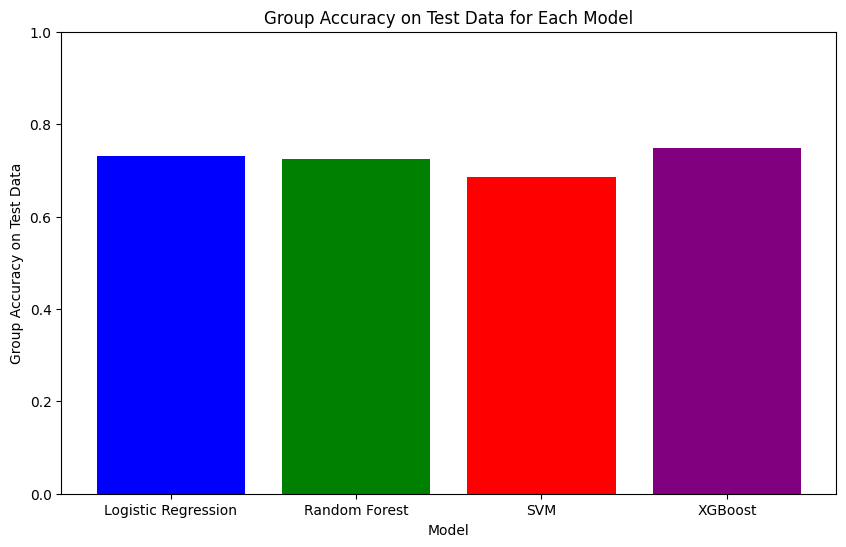

In [ ]:
import matplotlib.pyplot as plt

# Assuming `results` dictionary contains the group accuracy for each model
# Example structure of `results` dictionary:
results = {
    'Logistic Regression': {'group_accuracy_test': 0.7309},
     'Random Forest': {'group_accuracy_test': 0.7242},
     'SVM': {'group_accuracy_test': 0.6845},
     'XGBoost': {'group_accuracy_test': 0.7481}
 }

# Extract model names and their corresponding group accuracies on test data
model_names = list(results.keys())
group_accuracies = [results[model]['group_accuracy_test'] for model in model_names]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, group_accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Group Accuracy')
plt.title('Group Accuracy on Test Data')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.show()

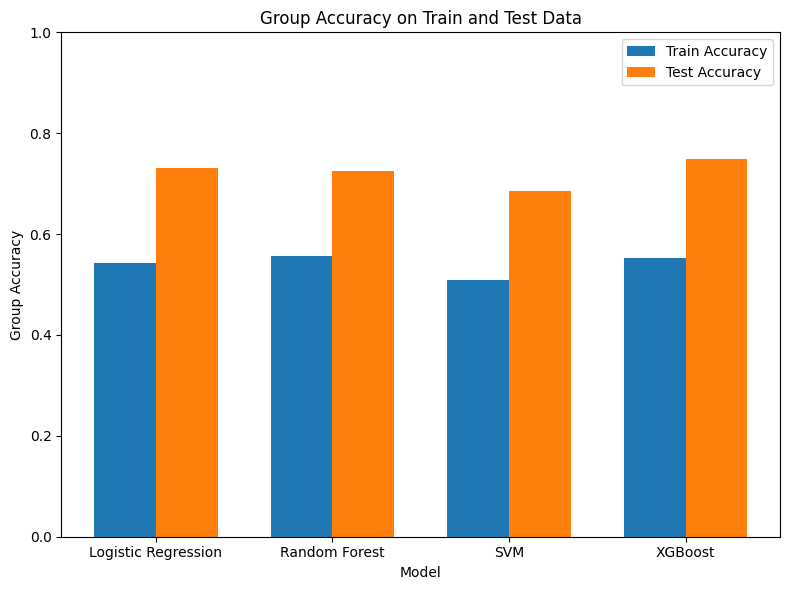

In [169]:
import numpy as np

import matplotlib.pyplot as plt

# Data from the summary of results
models = ['Logistic Regression', 'Random Forest', 'SVM', 'XGBoost']
train_accuracies = [0.5435, 0.5569, 0.5086, 0.5520]
test_accuracies = [0.7309, 0.7242, 0.6845, 0.7481]

# Plotting
x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Train Accuracy')
rects2 = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Model')
ax.set_ylabel('Group Accuracy')
ax.set_title('Group Accuracy on Train and Test Data')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

fig.tight_layout()

plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.show()

### Feature selection and Hyperparameter tuning

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

# -----------------------------------
# Define the Logistic Regression Pipeline
# -----------------------------------
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(score_func=f_classif)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# -----------------------------------
# Define the Hyperparameter Grid for Logistic Regression
# -----------------------------------
param_grid_logreg = {
    'selector__k': [10, 20, 25],  # Number of features to select
    'classifier__C': [0.1, 1, 10],  # Regularization strength
    'classifier__solver': ['liblinear', 'lbfgs'],  # Solvers suitable for logistic regression
    'classifier__penalty': ['l1', 'l2'],  # Regularization types
}

# -----------------------------------
# Define GroupKFold Cross-Validator
# -----------------------------------
group_kfold = GroupKFold(n_splits=5)

# -----------------------------------
# Initialize GridSearchCV for Logistic Regression
# -----------------------------------
grid_search_logreg = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid_logreg,
    scoring='accuracy',  # Customize scoring if needed
    cv=group_kfold,
    verbose=2,
    n_jobs=-1
)

# -----------------------------------
# Fit GridSearchCV on Training Data
# -----------------------------------
print("Starting Grid Search for Logistic Regression...")
grid_search_logreg.fit(X_train, y_train, groups=train_df['raceId'])

# -----------------------------------
# Best Logistic Regression Model
# -----------------------------------
best_logreg = grid_search_logreg.best_estimator_
print("Best Logistic Regression Parameters:", grid_search_logreg.best_params_)

# -----------------------------------
# Predict on Test Set
# -----------------------------------
y_proba_test_logreg = best_logreg.predict_proba(X_test)

# -----------------------------------
# Calculate Test Group Accuracy
# -----------------------------------
test_group_accuracy_logreg2 = calculate_group_accuracy(
    y_true=y_test.reset_index(drop=True),
    y_proba=y_proba_test_logreg,
    race_ids=test_df['raceId'].reset_index(drop=True),
    classes=best_logreg.named_steps['classifier'].classes_
)

print("\nSummary of Results:")
print(f"Logistic Regression (Group Accuracy):")
print(f" - Best Parameters: {grid_search_logreg.best_params_}")
print(f" - Group Accuracy on test data: {test_group_accuracy_logreg2:.4f}")


Starting Grid Search for Logistic Regression...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Logistic Regression Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'selector__k': 20}

Summary of Results:
Logistic Regression (Group Accuracy):
 - Best Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'selector__k': 20}
 - Group Accuracy on test data: 0.7454


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.feature_selection import SelectKBest, f_classif

# -----------------------------------
# Define the Random Forest Pipeline
# -----------------------------------
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(score_func=f_classif)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# -----------------------------------
# Define the Hyperparameter Grid for Random Forest
# -----------------------------------
param_grid_rf = {
    'selector__k': [10, 20, 25],  
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
}

# -----------------------------------
# Define GroupKFold Cross-Validator
# -----------------------------------
group_kfold = GroupKFold(n_splits=5)

# -----------------------------------
# Initialize GridSearchCV for Random Forest
# -----------------------------------
grid_search_rf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid_rf,
    scoring='accuracy',  # You can customize this if needed
    cv=group_kfold,
    verbose=2,
    n_jobs=-1
)

# -----------------------------------
# Fit GridSearchCV on Training Data
# -----------------------------------
print("Starting Grid Search for Random Forest...")
grid_search_rf.fit(X_train, y_train, groups=train_df['raceId'])

# -----------------------------------
# Best Random Forest Model
# -----------------------------------
best_rf = grid_search_rf.best_estimator_
print("Best Random Forest Parameters:", grid_search_rf.best_params_)

# -----------------------------------
# Predict on Test Set
# -----------------------------------
y_proba_test_rf = best_rf.predict_proba(X_test)

# -----------------------------------
# Calculate Test Group Accuracy
# -----------------------------------
test_group_accuracy_rf2 = calculate_group_accuracy(
    y_true=y_test.reset_index(drop=True),
    y_proba=y_proba_test_rf,
    race_ids=test_df['raceId'].reset_index(drop=True),
    classes=best_rf.named_steps['classifier'].classes_
)

print("\nSummary of Results:")
print(f"Random Forest (Group Accuracy):")
print(f" - Best Parameters: {grid_search_rf.best_params_}")
print(f" - Group Accuracy on test data: {test_group_accuracy_rf2:.4f}")


Starting Grid Search for Random Forest...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Random Forest Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100, 'selector__k': 20}

Summary of Results:
Random Forest (Group Accuracy):
 - Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100, 'selector__k': 20}
 - Group Accuracy on test data: 0.7448


In [ ]:
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, GroupKFold

# -----------------------------------
# Define the SVM Pipeline
# -----------------------------------
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(score_func=f_classif)),
    ('classifier', SVC(probability=True, random_state=42))
])

# -----------------------------------
# Define the Hyperparameter Grid for SVM
# -----------------------------------
param_grid_svm = {
    'selector__k': [10, 20, 25],
    'classifier__C': [0.1, 1],
    'classifier__kernel': ['rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto'],
}
# -----------------------------------
# Define GroupKFold Cross-Validator
# -----------------------------------
group_kfold = GroupKFold(n_splits=5)

# -----------------------------------
# Initialize GridSearchCV for SVM
# -----------------------------------
grid_search_svm = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid_svm,
    scoring='accuracy',
    cv=group_kfold,
    verbose=2,
    n_jobs=-1
)

# -----------------------------------
# Fit GridSearchCV on Training Data
# -----------------------------------
print("Starting Grid Search for SVM...")
grid_search_svm.fit(X_train, y_train, groups=train_df['raceId'])

# -----------------------------------
# Best SVM Model
# -----------------------------------
best_svm = grid_search_svm.best_estimator_
print("Best SVM Parameters:", grid_search_svm.best_params_)

# -----------------------------------
# Predict on Test Set
# -----------------------------------
y_proba_test_svm = best_svm.predict_proba(X_test)

# -----------------------------------
# Calculate Test Group Accuracy
# -----------------------------------
test_group_accuracy_svm2 = calculate_group_accuracy(
    y_true=y_test.reset_index(drop=True),
    y_proba=y_proba_test_svm,
    race_ids=test_df['raceId'].reset_index(drop=True),
    classes=best_svm.named_steps['classifier'].classes_
)

print("\nSummary of Results:")
print(f"SVM (Group Accuracy):")
print(f" - Best Parameters: {grid_search_svm.best_params_}")
print(f" - Group Accuracy on test data: {test_group_accuracy_svm2:.4f}")


Starting Grid Search for SVM...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [ ]:
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, GroupKFold

# -----------------------------------
# Define the XGBoost Pipeline
# -----------------------------------
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(score_func=f_classif)),
    ('classifier', XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    ))
])

# -----------------------------------
# Define the Hyperparameter Grid for XGBoost
# -----------------------------------
param_grid_xgb = {
    'selector__k': [10, 20, 25],
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.001, 0.01, 0.1],
    'classifier__min_child_weight': [1, 3],
    'classifier__gamma': [0, 0.1, 0.2]
}

# -----------------------------------
# Define GroupKFold Cross-Validator
# -----------------------------------
group_kfold = GroupKFold(n_splits=5)

# -----------------------------------
# Initialize GridSearchCV for XGBoost
# -----------------------------------
grid_search_xgb = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid_xgb,
    scoring='accuracy',
    cv=group_kfold,
    verbose=2,
    n_jobs=-1
)

# -----------------------------------
# Fit GridSearchCV on Training Data
# -----------------------------------
print("Starting Grid Search for XGBoost...")
grid_search_xgb.fit(X_train, y_train, groups=train_df['raceId'])

# -----------------------------------
# Best XGBoost Model
# -----------------------------------
best_xgb = grid_search_xgb.best_estimator_
print("Best XGBoost Parameters:", grid_search_xgb.best_params_)

# -----------------------------------
# Predict on Test Set
# -----------------------------------
y_proba_test_xgb = best_xgb.predict_proba(X_test)

# -----------------------------------
# Calculate Test Group Accuracy
# -----------------------------------
test_group_accuracy_xgb2 = calculate_group_accuracy(
    y_true=y_test.reset_index(drop=True),
    y_proba=y_proba_test_xgb,
    race_ids=test_df['raceId'].reset_index(drop=True),
    classes=best_xgb.named_steps['classifier'].classes_
)

print("\nSummary of Results:")
print(f"XGBoost (Group Accuracy):")
print(f" - Best Parameters: {grid_search_xgb.best_params_}")
print(f" - Group Accuracy on test data: {test_group_accuracy_xgb2:.4f}")


Starting Grid Search for XGBoost...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\joelc\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:15:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost Parameters: {'classifier__gamma': 0.2, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 100, 'selector__k': 10}

Summary of Results:
XGBoost (Group Accuracy):
 - Best Parameters: {'classifier__gamma': 0.2, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 100, 'selector__k': 10}
 - Group Accuracy on test data: 0.7490


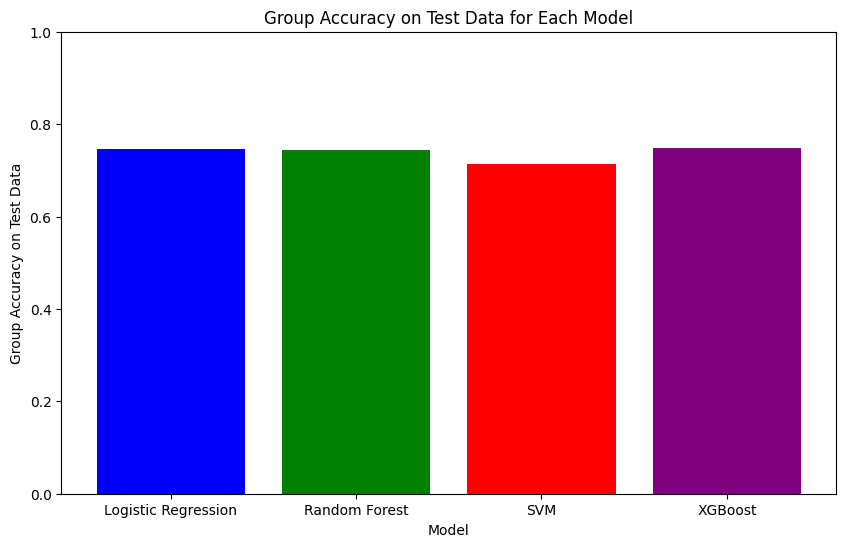

In [ ]:
import matplotlib.pyplot as plt

# Assuming `results` dictionary contains the group accuracy for each model
# Example structure of `results` dictionary:
results = {
    'Logistic Regression': {'group_accuracy_test': 0.7454},
     'Random Forest': {'group_accuracy_test': 0.7448},
     'SVM': {'group_accuracy_test': 0.7135},
     'XGBoost': {'group_accuracy_test': 0.7490}
 }

# Extract model names and their corresponding group accuracies on test data
model_names = list(results.keys())
group_accuracies = [results[model]['group_accuracy_test'] for model in model_names]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, group_accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Group Accuracy')
plt.title('Group Accuracy on Test Data')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.show()

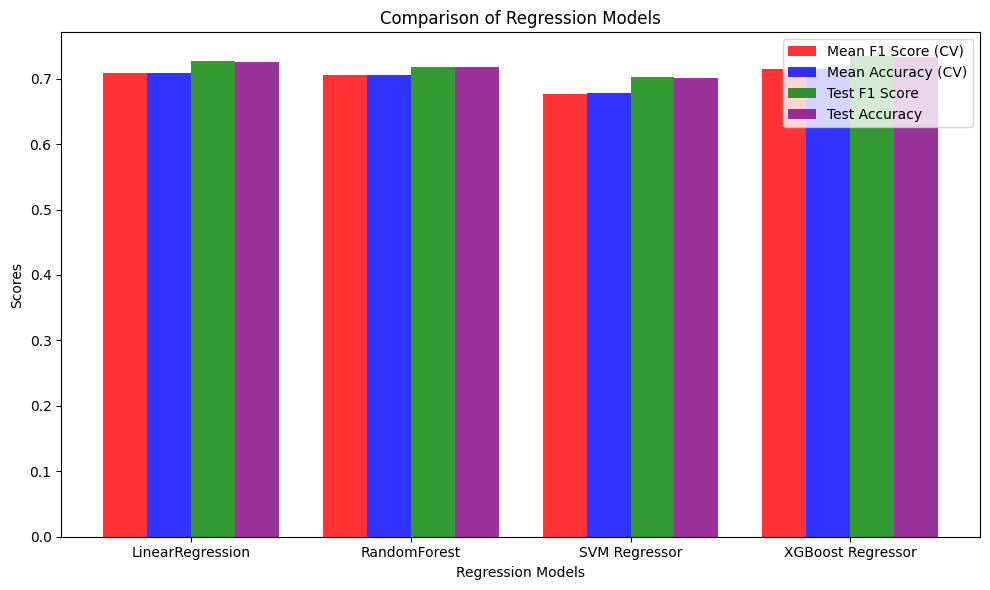

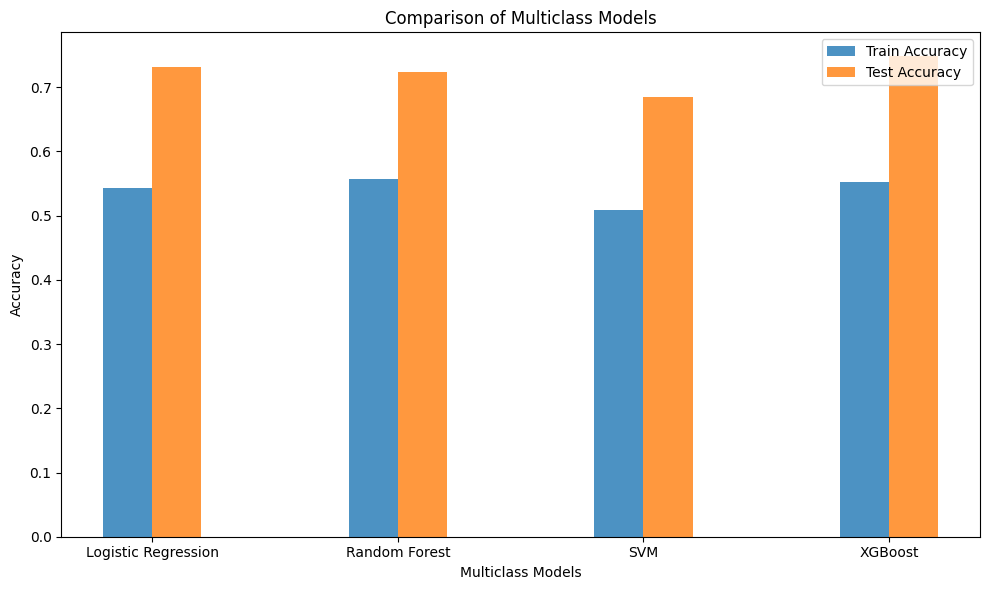

In [5]:
import matplotlib.pyplot as plt
import numpy as np


# Regression data
regression_models = ['LinearRegression', 'RandomForest', 'SVM Regressor', 'XGBoost Regressor']
regression_mean_f1 = [0.7092, 0.7058, 0.6768, 0.7142]
regression_mean_accuracy = [0.7094, 0.7060, 0.6774, 0.7145]
regression_test_f1 = [0.7273, 0.7180, 0.7027, 0.7341]
regression_test_accuracy = [0.7262, 0.7176, 0.7017, 0.7328]

# Multiclass data
multiclass_models = ['Logistic Regression', 'Random Forest', 'SVM', 'XGBoost']
multiclass_train_accuracy = [0.5435, 0.5569, 0.5086, 0.5520]
multiclass_test_accuracy = [0.7309, 0.7242, 0.6845, 0.7481]

# Plot for regression models
x = np.arange(len(regression_models))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, regression_mean_f1, width, label='Mean F1 Score (CV)', alpha=0.8, color='red')
ax.bar(x, regression_mean_accuracy, width, label='Mean Accuracy (CV)', alpha=0.8, color='blue')
ax.bar(x + width, regression_test_f1, width, label='Test F1 Score', alpha=0.8, color='green')
ax.bar(x + 2*width, regression_test_accuracy, width, label='Test Accuracy', alpha=0.8, color='purple')

ax.set_xlabel('Regression Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Regression Models')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(regression_models)
ax.legend()
plt.tight_layout()
plt.show()

# Plot for multiclass models
x_multiclass = np.arange(len(multiclass_models))

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x_multiclass - width / 2, multiclass_train_accuracy, width, label='Train Accuracy', alpha=0.8)
ax.bar(x_multiclass + width / 2, multiclass_test_accuracy, width, label='Test Accuracy', alpha=0.8)

ax.set_xlabel('Multiclass Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Multiclass Models')
ax.set_xticks(x_multiclass)
ax.set_xticklabels(multiclass_models)
ax.legend()
plt.tight_layout()
plt.show()

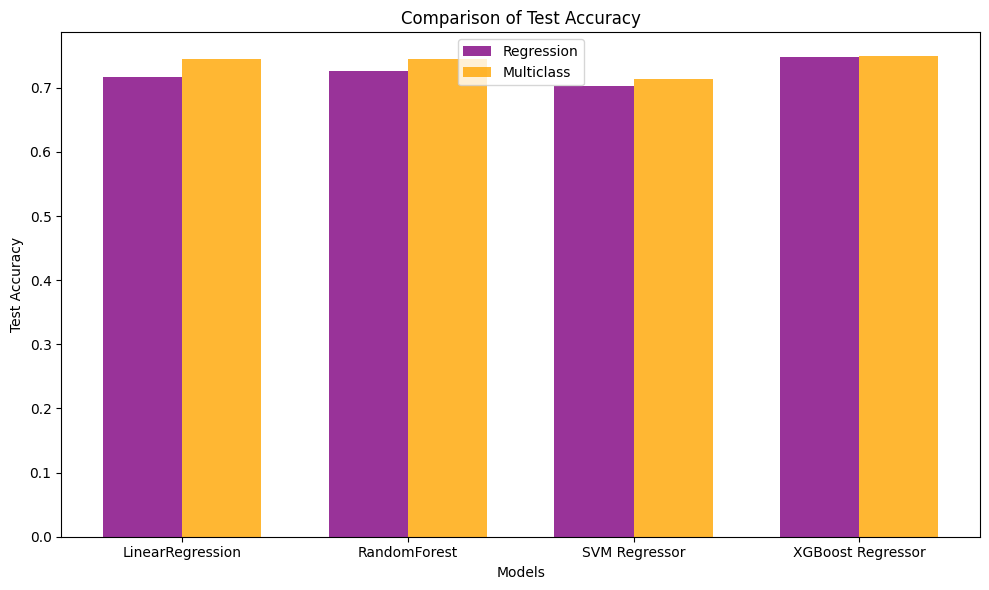

In [4]:
# Data for regression and multiclass models after feature selection and hyperparameter tuning
regression_models_updated = ['LinearRegression', 'RandomForest', 'SVM Regressor', 'XGBoost Regressor']
regression_test_accuracy_updated = [0.7175, 0.7261, 0.7031, 0.7476]

multiclass_models_updated = ['Logistic Regression', 'Random Forest', 'SVM', 'XGBoost']
multiclass_test_accuracy_updated = [0.7454, 0.7448, 0.7135, 0.7490]

# Combined plot
fig, ax = plt.subplots(figsize=(10, 6))
x_combined = np.arange(len(regression_models_updated))
width = 0.35

# Bar plot for regression models
ax.bar(x_combined - width / 2, regression_test_accuracy_updated, width, label='Regression', alpha=0.8, color='purple')

# Bar plot for multiclass models
ax.bar(x_combined + width / 2, multiclass_test_accuracy_updated, width, label='Multiclass', alpha=0.8, color='orange')

ax.set_xlabel('Models')
ax.set_ylabel('Test Accuracy')
ax.set_title('Comparison of Test Accuracy')
ax.set_xticks(x_combined)
ax.set_xticklabels(regression_models_updated)
ax.legend()
plt.tight_layout()
plt.show()
